<h1>Exploring the resting brain with topological data analysis<span class="tocSkip"></span></h1>

<br>
<font size="4">Rafi Ayub<sup>1,3</sup> and Caleb Geniesse<sup>2,3</sup></font>
<br>
<br>
<sup>1</sup> Department of Bioengineering, Stanford University<br>
<sup>2</sup> Biophysics Program, Stanford University<br>
<sup>3</sup> Department of Psychiatry and Behavioral Sciences, Stanford University<br>

> The dynamics of the brain at rest are not well understood, yet their dysregulation has been linked to psychiatric disease. Even in healthy subjects, everyday changes in arousal and mood can alter brain dynamics, but their exact impact is not clear. Current methods to reveal the intricate interplay between brain regions and networks rely on linear approaches and correlations that may miss the non-linear structure of these relationships. In this study we apply Mapper, a tool from the field of topological data analysis, that uses non-linear approaches to learn the underlying shape of the data. We explore the MyConnectome dataset, which consists of a complete metabolic profile and fMRI scans of a single subject across the span of an entire year. We construct graphs comparing the fed/caffeinated state, the fasted/uncaffeinated state, and a random graph model using SBM. We found that the fasted state exhibits increased participation coefficient across almost all resting state networks compared to fed state. Both real brain graphs showed higher participation coefficient and higher within-module connectivity across all resting state networks than the null model, demonstrating the brains ability to optimize the balance between integration and segregation of function. The results from this study show that Mapper can reveal important anatomical and functional architecture of the human brain.

# Introduction #
      
The brain is a multitasking machine; while it manages the effortless heartbeats and breaths that keep it alive, it is also able to yield intense focus on reading a paper, performing mathematical calculations, or driving a car. Neuroscience has explored the functional repertoire of the brain by pinpointing the anatomical correlates to hundreds of simple tasks and imaging the evolution of brain activity during cognitive demands. Yet, there is still no certainty on what the brain does when it is at rest, performing no task at all.

Scientists, philosophers, and the everyday thinker posit that the mind wanders, daydreams, ruminates, reflects, and plans. This rich palette of cognitive behaviour has found some basis within neuroimaging. For example, functional MR imaging studies have observed correlations between distant brain regions in spontaneous activity during rest, deemed resting state functional connectivity (FC) <a href="#References">[1]</a><a href="#References">[2]</a>. Across a longer time interval of resting state activity, patterns of correlated networks and sub-networks form and dissolve in simulations and in empirical data <a href="#References">[3]</a>. In fact, many of these canonical resting state networks (RSNs) have been found across many studies and have corresponded to critical brain functions such as movement, attention, and vision. Interestingly, these networks and connectivity between certain regions may be impaired in neuropsychiatric disorders such as Alzheimer’s disease and depression <a href="#References">[4]</a>. Even outside of psychiatric disorders, the physiological state of a subject can impact the functional connectivity of the resting brain. For example, a subject in a fasted state exhibited greater connectivity within the somatomotor and dorsal attention networks <a href="#References">[5]</a>. Clearly, exploring the brain at rest could yield key insight into its function and dynamics.

Current methods to characterize resting state FC involve timeseries correlations between regions, sliding-window correlations, deconvolution, temporal Independent Component Analysis, and more. Many of these are linear methods that may fail to reveal non-linear relationships between brain regions and resting state networks. To explore the nuances of these interactions, a tool from the field of Topological Data Analysis called Mapper has been proposed. Mapper creates a combinatorial object from a high dimensional dataset that depicts the manifold of the original data. By using metrics from graph theory, clinically and biophysically relevant insight can be captured from a Mapper graph applied to resting state fMRI data. This approach has been previously used to predict individual task performance and capture cognitive task transitions at a faster time scale than other methods. <a href="#References">[6]</a>

In this study, we used Mapper to explore the structure of RSNs in resting state fMRI data. We used 84 cleaned scan sessions, of which 31 were of the fed state and 40 were of the fasted state, from the dataset provided by MyConnectome, which consists of structural and functional MR scan sessions, metabolic profiles, mood questionnaires, and daily activity logs of the same subject for about a year. Specifically, we analyzed the community structure, betweenness centrality, within-module degree, and participation coefficient of RSNs and compared them between fed and fasted states. We also created a null model using the Stochastic Block Model, which can recreate the community structure of the Mapper graphs.

Community and core structure will provide us insight into the diversity of network dynamics in the individual’s brain. We hypothesize that a more modular, smaller core graph of the patient’s brain correlates with a more alert profile for that scan day, and attention related RSNs congregate in the core more with an alert profile than a less alert profile. By characterizing the structure of the brain at rest and its relationship to behaviour, we can become better equipped to predict, diagnose, and treat neuropsychiatric disorders.



## Revealing complex topology of brain dynamics with Mapper ###

Mapper has found success in exploring the functional architecture of the brain under task demands. In Saggar et. al. <a href="#References">[6]</a>, the investigators applied Mapper to multitask fMRI data, where subjects were required to perform working memory, math, and video tasks in the scanner, with periods of rest and instructions in between. They found that nodes with members associated with tasks with heavy cognitive load (nodes can have multiple labeled members, see Mapper subsection in Methods for explanation) were concentrated in the core of the graph and nodes associated with resting tasks were localized in the periphery. Additionally, subjects with a more modular graph, where communities are assigned by majority vote of the nodes' members, had better task performance than individuals with a less modular graph. The results from this study show that Mapper can reveal complex functional dynamics of the brain. The resultant graphs provide a robust visualization that can link brain dynamics with cognitive and behavioral properties of an individual. We extend this method to resting-state data, where we may be able to reveal important topological features and link them to behavior or cognitive state.


# Setup # 

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
# data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# data analysis
import numpy as np
import pandas as pd
import scipy.stats

In [4]:
# sci-kit learn
from sklearn.datasets.base import Bunch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import DBSCAN

# other machine learning 
from umap.umap_ import UMAP
from hdbscan import HDBSCAN

Note, the  `dyneusr` library has not been released yet, as the manuscript introducing it is currently under review.

In [5]:
# Mapper 
import dyneusr as ds
import kmapper as km

# network analysis
import networkx as nx
import bct

Note, some of the code developed for analysis has been moved into seperate files, and need to be imported.

- `load_data.py`: includes code for loading and preprocessing the data

- `utils.py`: includes additional analysis and utility code developed for this project

In [6]:
# project code
from utils import load_scrubbed, combine_sessions
from utils import Config, run_mapper, get_data_splits, draw_G

## Experimental settings and parameters ##

In [7]:
config = Config()

# general 
config.verbose = 1
config.seed = 123

    
# data settings  (only use 10 sessions for testing, use -1 for all sessions)
#config.n_sessions = 20
config.data = Config()
config.data.seed = config.seed
config.data.shuffle = False #True
config.data.n_sessions = -1
config.data.n_sessions_split = 1
config.data.apply_tmask = True
config.data.apply_rmask = True
config.data.rmask_kwds = dict(n=12, minor=False)
config.data.zscore_data = False
config.data.zscore_meta = False
config.data.merge = False
config.data.clean_meta = False

In [8]:
np.random.seed(config.get('seed'))

# Data and Preprocessing #

## Data: $MyConnectome$ ##


In [9]:
from load_data import load_scrubbed, combine_sessions, clean_meta

## Load data ##


In [10]:
# Load sessions as seperate datasets.
sessions = load_scrubbed(**config.data)

INFO:load_data:load_scrubbed(**{'seed': 123, 'shuffle': False, 'n_sessions': -1, 'n_sessions_split': 1, 'apply_tmask': True, 'apply_rmask': True, 'rmask_kwds': {'n': 12, 'minor': False}, 'zscore_data': False, 'zscore_meta': False, 'merge': False, 'clean_meta': False})
INFO:load_data:Loading data...


[+] session: 0, file: sub014.txt | keeping: 505 (time points) | keeping: 554 (regions) | 
[+] session: 1, file: sub015.txt | keeping: 508 (time points) | keeping: 554 (regions) | 
[+] session: 2, file: sub016.txt | keeping: 508 (time points) | keeping: 554 (regions) | 
[+] session: 3, file: sub017.txt | keeping: 504 (time points) | keeping: 554 (regions) | 
[+] session: 4, file: sub018.txt | keeping: 508 (time points) | keeping: 554 (regions) | 
[+] session: 5, file: sub019.txt | keeping: 513 (time points) | keeping: 554 (regions) | 
[+] session: 6, file: sub020.txt | keeping: 446 (time points) | keeping: 554 (regions) | 
[+] session: 7, file: sub021.txt | keeping: 501 (time points) | keeping: 554 (regions) | 
[+] session: 8, file: sub022.txt | keeping: 511 (time points) | keeping: 554 (regions) | 
[+] session: 9, file: sub023.txt | keeping: 401 (time points) | keeping: 554 (regions) | 
[+] session: 10, file: sub024.txt | keeping: 494 (time points) | keeping: 554 (regions) | 
[+] sessi

In [11]:
# Load sessions as a single concated dataset.
combined = combine_sessions(sessions, zscore_meta=True, clean_meta=True)

[+] session: 0, file: sub014
[+] session: 1, file: sub015
[+] session: 2, file: sub016
[+] session: 3, file: sub017
[+] session: 4, file: sub018
[+] session: 5, file: sub019
[+] session: 6, file: sub020
[+] session: 7, file: sub021
[+] session: 8, file: sub022
[+] session: 9, file: sub023
[+] session: 10, file: sub024
[+] session: 11, file: sub025
[+] session: 12, file: sub026
[+] session: 13, file: sub027
[+] session: 14, file: sub028
[+] session: 15, file: sub029
[+] session: 16, file: sub030
[+] session: 17, file: sub032
[+] session: 18, file: sub035
[+] session: 19, file: sub036
[+] session: 20, file: sub037
[+] session: 21, file: sub038
[+] session: 22, file: sub039
[+] session: 23, file: sub040
[+] session: 24, file: sub041
[+] session: 25, file: sub042
[+] session: 26, file: sub043
[+] session: 27, file: sub044
[+] session: 28, file: sub045
[+] session: 29, file: sub046
[+] session: 30, file: sub047
[+] session: 31, file: sub048
[+] session: 32, file: sub049
[+] session: 33, fil

/Users/calebgeniesse/src/miniconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py:533: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


## Split data into $fasted$, $fed$ ##

In [12]:
# Split dataset into  (fast, fed) sessions.
splits = get_data_splits(
    combined, #zscore=True, 
    groupby='day_of_week', 
    groups={2: 'fast', 4: 'fed'},
    )

1               => day_of_week_0    x.shape: (5893, 554)  RSN.shape: (5893, 12)
2               => fast             x.shape: (20262, 554)  RSN.shape: (20262, 12)
4               => fed              x.shape: (15576, 554)  RSN.shape: (15576, 12)
Fri             => day_of_week_3    x.shape: (510, 554)  RSN.shape: (510, 12)


# Methods #

## $MAPPER$ ##

In [13]:
from utils import run_mapper

## Graph Annotation ##


### Resting state network labels ###

In [188]:
from utils import get_RSN_map, RSN_LABELS


# get RSNs from rmask, get RSN mapping (n=# networks)
df_roi_rsn, df_rsn_labels = get_RSN_map(combined.atlas, n=12)
RSNs = df_rsn_labels.network.copy()

RSN: Cingulo_opercular  (size=115)
RSN: DMN  (size=53)
RSN: Dorsal_Attention  (size=15)
RSN: Frontoparietal 2  (size=16)
RSN: Frontoparietal_1  (size=112)
RSN: Medial_Parietal  (size=11)
RSN: Parieto_occipital  (size=17)
RSN: Salience  (size=11)
RSN: Somatomotor  (size=90)
RSN: Ventral_Attention  (size=27)
RSN: Visual_1  (size=20)
RSN: Visual_2  (size=67)


In [15]:
df_roi_rsn.T

0    1    2    3    4    5    6    7    8    9   ...   620  \
Cingulo_opercular    0    0    0    0    0    0    0    0    0    0 ...     0   
Frontoparietal_1     0    0    0    0    0    0    1    0    0    0 ...     0   
Somatomotor          0    1    1    0    0    0    0    1    0    0 ...     0   
Visual_2             0    0    0    0    1    1    0    0    0    0 ...     0   
DMN                  1    0    0    0    0    0    0    0    0    1 ...     0   
Dorsal_Attention     0    0    0    0    0    0    0    0    0    0 ...     0   
Ventral_Attention    0    0    0    1    0    0    0    0    0    0 ...     0   
Salience             0    0    0    0    0    0    0    0    0    0 ...     0   
Visual_1             0    0    0    0    0    0    0    0    0    0 ...     0   
Medial_Parietal      0    0    0    0    0    0    0    0    1    0 ...     0   
Parieto_occipital    0    0    0    0    0    0    0    0    0    0 ...     0   
Frontoparietal 2     0    0    0    0    0    0    0    0    0    0 ...     0   

                   621  622  623  624  625  626  627  628  629  
Cingulo_opercular    0    0    0    0    0    0    0    0    0  
Frontoparietal_1     0    0    0    0    0    0    0    0    0  
Somatomotor          0    0    0    0    0    0    0    0    0  
Visual_2             0    0    0    0    0    0    0    0    0  
DMN                  0    0    0    0    0    0    0    0    0  
Dorsal_Attention     0    0    0    0    0    0    0    0    0  
Ventral_Attention    0    0    0    0    0    0    0    0    0  
Salience             0    0    0    0    0    0    0    0    0  
Visual_1             0    0    0    0    0    0    0    0    0  
Medial_Parietal      0    0    0    0    0    0    0    0    0  
Parieto_occipital    0    0    0    0    0    0    0    0    0  
Frontoparietal 2     0    0    0    0    0    0    0    0    0  

[12 rows x 630 columns]

## Network Analysis ##

In [16]:
from utils import get_mod, within_module_degree, betweenness, calc_particip

In [17]:
from utils import plot_network_measure

## ROI x ROI Adjacency ##

<img src="reports/figures/mapper_matrices.png" width="50%">


In [18]:
from utils import plot_network_adj

## Null Stochastic Block Model ##

In [19]:
from utils import nullSBM

# init, config, run
SBM = nullSBM()
#SBM.configure(sessions[1], y=df_roi_rsn, **config)
#SBM.run(1)

# visualize
#fig = plt.figure(figsize=(15, 5))
#SBM.plot(ax=fig.add_subplot(131), figure=fig, show=False, add_cbar=False)
#SBM.draw(ax=fig.add_subplot(132), figure=fig)
#SBM.draw(ax=fig.add_subplot(133), figure=fig, layout='spring')

# Results #


- We start by making one giant Mapper graph for all of fed, all of fasted
- Below, we run Mapper graph across individual sessions, and visualize average network measures 

## $MAPPER$ analysis of $fasted$ vs. $fed$ state from combined sessions ##

Here, Mapper graphs are created by running once on all scans concatenated for fasted state, and then fed state.

### Annotate $MAPPER$ graphs with RSN labels ###

Color graphs similar to Figure 4 in (Poldrack, 2015) 

<img src="reports/figures/poldrack_figure4.jpg" width="50%">

<img src="figures/fast_super_ColorRSNsPoldrack.png" width="50%">
<img src="figures/fed_super_ColorRSNsPoldrack.png" width="50%">

In [207]:
rsn_target, rsn_labels = pd.factorize(combined.atlas.data.network.values)
rsn_columns = list(rsn_labels[rsn_target])
rsn_major = ['Somatomotor', 'Visual_2', 'Cingulo_opercular', 'Frontoparietal_1', 'DMN']
rsn_pretty = ['somatomotor', 'second visual', 'cingulo-opercular', 'fronto-parietal', 'default mode']
rsn_colors = ['red', 'blue', 'purple', 'yellow', 'black']

# now reorder and define mappings
#rsn_labels = sorted(rsn_labels)
rsn_sorted = sorted(rsn_labels)
rsn_sorted = [dict(zip(rsn_major, rsn_major)).get(_, None) for _ in rsn_sorted]
rsn_pretty = [dict(zip(rsn_major, rsn_pretty)).get(_, None) for _ in rsn_sorted]
rsn_colors = [dict(zip(rsn_major, rsn_colors)).get(_, 'lightgray') for _ in rsn_sorted]
df_rsn_colors = pd.DataFrame(dict(
    target=np.unique(rsn_target),
    label=sorted(rsn_labels),
    sorted=rsn_sorted, 
    pretty=rsn_pretty, 
    colors=rsn_colors
  )).sort_values('target').fillna('').reset_index(drop=True)

# save as dataframe, print
print(df_rsn_colors)

# define color map, convert to hex 
rsn_colormap = mpl.colors.ListedColormap(df_rsn_colors.colors)
rsn_colors = list(map(mpl.colors.to_hex, rsn_colormap.colors))

# define as dict of color functions
color_functions = dict(multiclass=np.ravel(rsn_colors))

# need to reindex columns so color functions match
df_roi_rsn = df_roi_rsn.loc[:, df_rsn_colors.label[:df_roi_rsn.columns.size]]

# get RSNs from poldrack 
df_poldrack = df_roi_rsn.copy()
df_poldrack.columns = df_rsn_colors.pretty[:df_poldrack.columns.size]
df_poldrack.T

    target              label             sorted             pretty     colors
0        0  Cingulo_opercular  Cingulo_opercular  cingulo-opercular     purple
1        1                DMN                DMN       default mode      black
2        2   Dorsal_Attention                                        lightgray
3        3   Frontoparietal 2                                        lightgray
4        4   Frontoparietal_1   Frontoparietal_1    fronto-parietal     yellow
5        5    Medial_Parietal                                        lightgray
6        6  Parieto_occipital                                        lightgray
7        7           Salience                                        lightgray
8        8        Somatomotor        Somatomotor        somatomotor        red
9        9  Ventral_Attention                                        lightgray
10      10           Visual_1                                        lightgray
11      11           Visual_2           Visual_2    

0    1    2    3    4    5    6    7    8    9   ...   620  \
pretty                                                              ...         
cingulo-opercular    0    0    0    0    0    0    0    0    0    0 ...     0   
default mode         1    0    0    0    0    0    0    0    0    1 ...     0   
                     0    0    0    0    0    0    0    0    0    0 ...     0   
                     0    0    0    0    0    0    0    0    0    0 ...     0   
fronto-parietal      0    0    0    0    0    0    1    0    0    0 ...     0   
                     0    0    0    0    0    0    0    0    1    0 ...     0   
                     0    0    0    0    0    0    0    0    0    0 ...     0   
                     0    0    0    0    0    0    0    0    0    0 ...     0   
somatomotor          0    1    1    0    0    0    0    1    0    0 ...     0   
                     0    0    0    1    0    0    0    0    0    0 ...     0   
                     0    0    0    0    0    0    0    0    0    0 ...     0   
second visual        0    0    0    0    1    1    0    0    0    0 ...     0   

                   621  622  623  624  625  626  627  628  629  
pretty                                                          
cingulo-opercular    0    0    0    0    0    0    0    0    0  
default mode         0    0    0    0    0    0    0    0    0  
                     0    0    0    0    0    0    0    0    0  
                     0    0    0    0    0    0    0    0    0  
fronto-parietal      0    0    0    0    0    0    0    0    0  
                     0    0    0    0    0    0    0    0    0  
                     0    0    0    0    0    0    0    0    0  
                     0    0    0    0    0    0    0    0    0  
somatomotor          0    0    0    0    0    0    0    0    0  
                     0    0    0    0    0    0    0    0    0  
                     0    0    0    0    0    0    0    0    0  
second visual        0    0    0    0    0    0    0    0    0  

[12 rows x 630 columns]

In [233]:
def color_lens_by_atlas(session_, colorby=None, cmap='nipy_spectral_r', figsize=None, layout=None, show=True):
    # extract data
    atlas = session_.atlas.data.loc[session_.rmask.data_id].copy()
    lens = session_.mapped.lens.copy()
    
    # init cmap
    if not callable(cmap):
        if np.ravel(cmap).size > 1:
            cmap = mpl.colors.ListedColormap(cmap)
    
    # init axes, columns
    if isinstance(colorby, list):
        atlas = atlas[colorby]
        layout = layout or (1, len(colorby))
        figsize or (8*len(colorby), 8)
    elif colorby in atlas.columns:
        atlas = atlas[[colorby]]
        layout = layout or (1, 1)
        figsize = figsize or (12, 8)
    else:
        atlas = atlas[['hemisphere', 'region', 'subregion', 'network', 8, 9]]
        layout = layout or (2, 3)
        figsize = figsize or (20, 12)

    
    # init figure from layout, figsize
    fig, axes = plt.subplots(*layout, figsize=figsize)
    
    # loop over columns, axes
    for column,ax in zip(atlas.columns, np.ravel(axes)):      
        # copy data
        data_ = atlas.copy()
        lens_ = lens.copy()
        
        # factorize colors, resample norm, cmap
        values = data_.reset_index(drop=True).sort_values(column)[column]
        colors, labels = pd.factorize(values.values)
        lens_ = lens_[values.index]

        # set color map
        cmap_ = cmap if callable(cmap) else plt.get_cmap(cmap, len(labels))
        
        # plot one layer for each label
        for c,l in enumerate(labels):        
            ax.scatter(*lens_[colors==c].T, c=cmap_(c), label=l)
        
        # finish
        if len(atlas.columns) == 1:            
            ax.legend(loc=2, bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        else:
            ax.legend(loc='upper right')
        ax.set_title(column, fontsize=24, fontweight='bold')
        ax.axis('equal')


    # finish
    plt.tight_layout()
    if show:
        plt.show()
    return fig, axes


### Generate $MAPPER$ graphs ###

#### Setup #### 

In [283]:
# mapper settings
config.mapper = Config()
config.mapper.zscore = False
config.mapper.y = df_roi_rsn.copy()
config.mapper.projection = UMAP(min_dist=0.3, n_neighbors=30)

projection = UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.3, n_components=2, n_epochs=None,
   n_neighbors=30, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=False)



In [278]:
# visualize settings
config.visualize = Config()
config.visualize.show = True
config.visualize.color_functions = color_functions

#### Run $MAPPER$, visualize graphs ####

cover = Cover({'n_cubes': 22, 'perc_overlap': 0.875, 'limits': array([[-0.03977273,  1.03977273],
       [-0.03977273,  1.03977273]])})

clusterer = DBSCAN(algorithm='auto', eps=224.9906570009764, leaf_size=30,
    metric='euclidean', metric_params=None, min_samples=1, n_jobs=1,
    p=None)



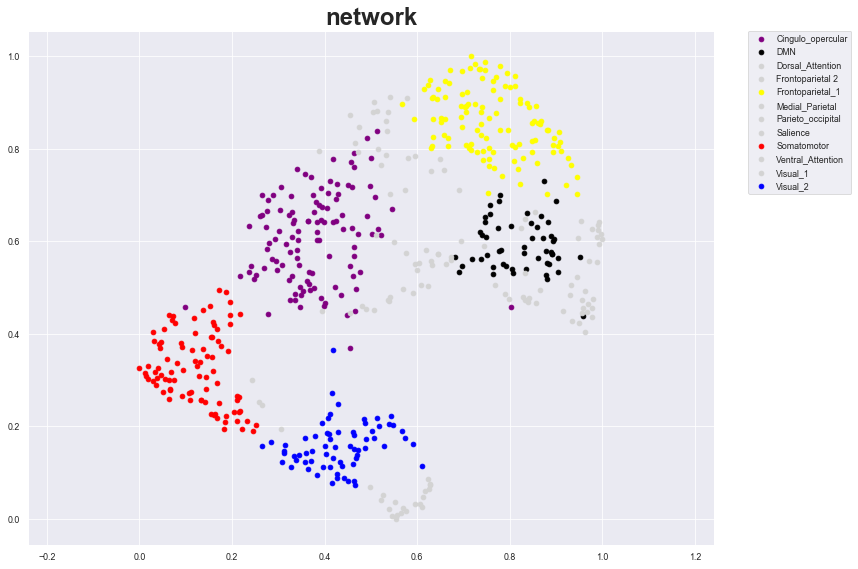

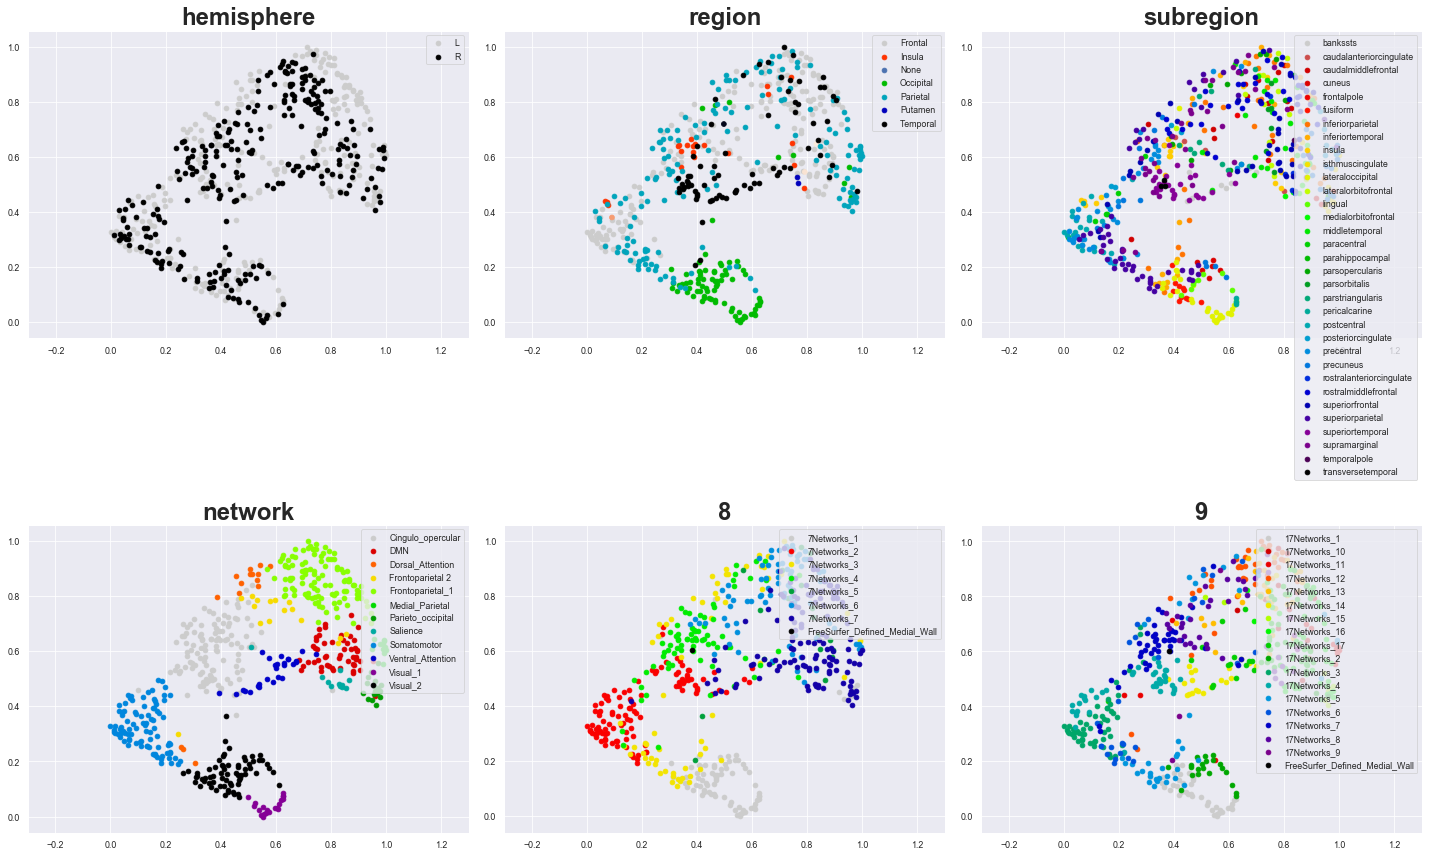

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/combined_spatial_color_RSN_poldrack.html


DyNeuGraph()

<Figure size 432x288 with 0 Axes>

In [285]:
from dyneusr.mapper.utils import optimize_dbscan, optimize_cover

# get optimized clusterer, cluster
XzT = scipy.stats.zscore(combined.X, axis=0).T
config.mapper.clusterer = optimize_dbscan(XzT, min_samples=1)
config.mapper.cover = optimize_cover(XzT, r=40, g=8, limits=True)

# print params
print("projection = {}\n".format(config.mapper.projection))
print("cover = Cover({})\n".format(config.mapper.cover.__dict__))
print("clusterer = {}\n".format(config.mapper.clusterer))

# run
combined.mapped = run_mapper(XzT, **config.mapper)
color_lens_by_atlas(combined, colorby='network', cmap=rsn_colormap)
color_lens_by_atlas(combined)
combined.mapped.dG.visualize('results/combined_spatial_color_RSN_poldrack.html', **config.visualize)

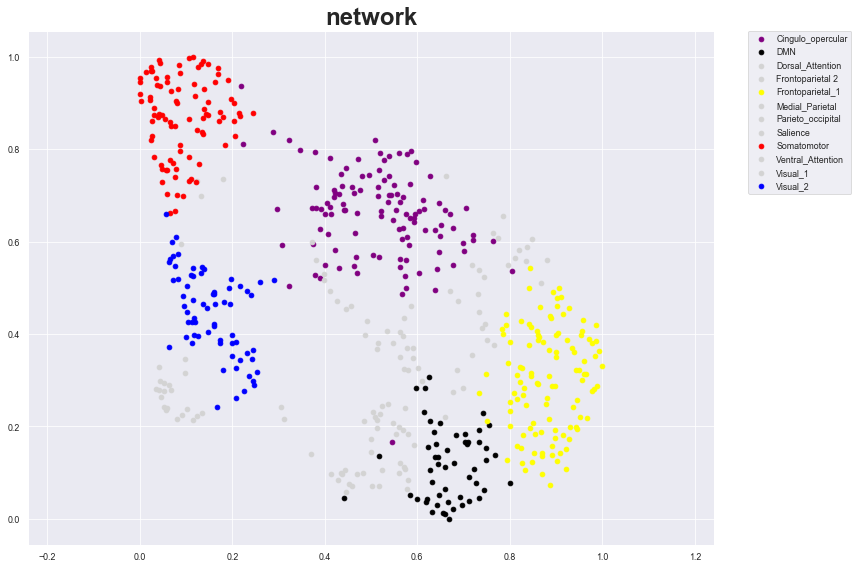

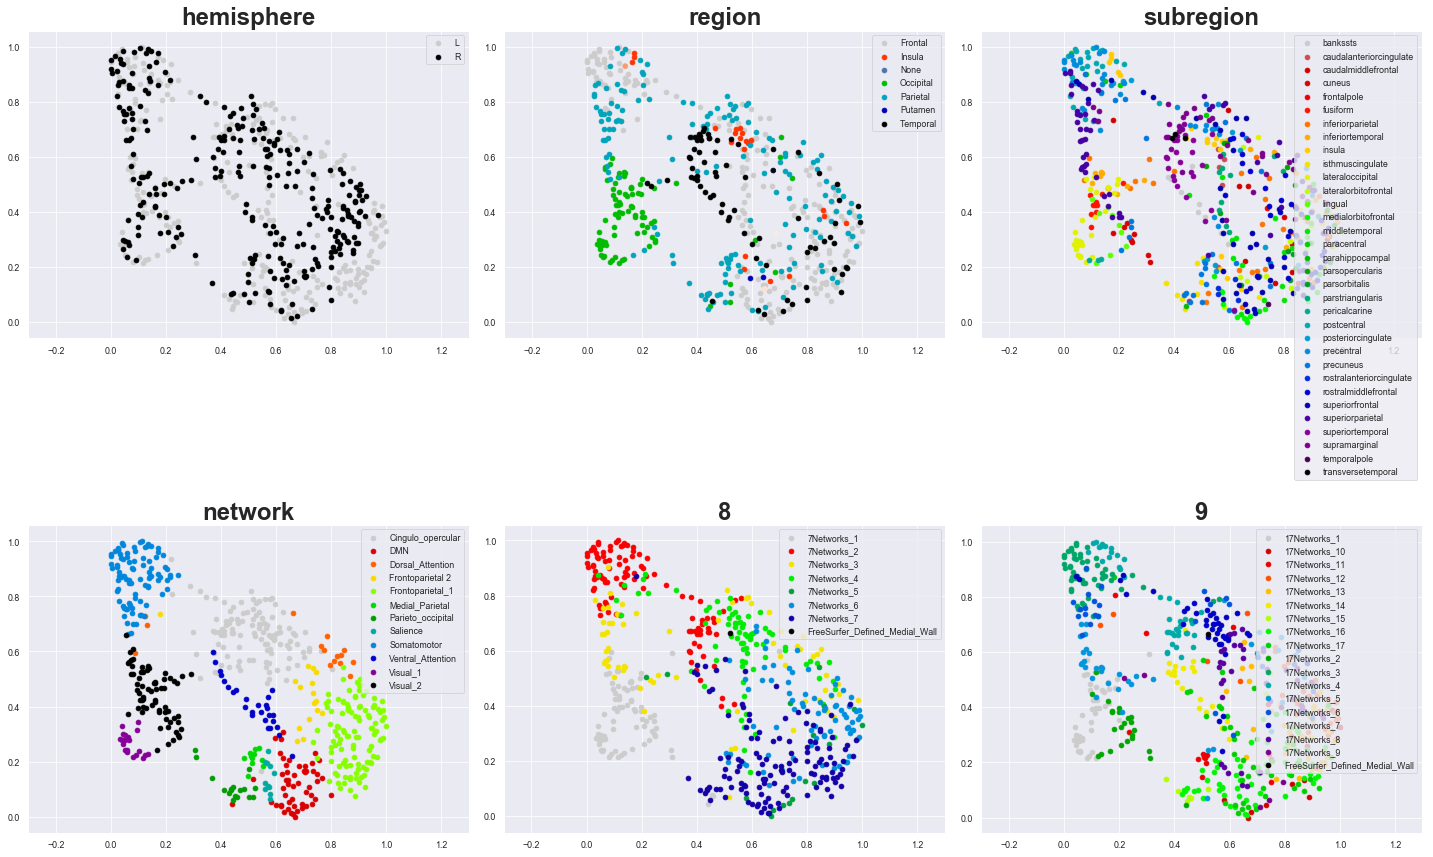

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/fast_spatial_color_RSN_poldrack.html


DyNeuGraph()

<Figure size 432x288 with 0 Axes>

In [289]:
# zscore across TRs
XzT = scipy.stats.zscore(splits.fast.X, axis=0).T

# get optimized clusterer, cluster
from dyneusr.mapper.utils import optimize_dbscan, optimize_cover
config.mapper.clusterer = optimize_dbscan(XzT, min_samples=1)
config.mapper.cover = optimize_cover(XzT, r=40, g=8, limits=True)

# print params
print("projection = {}\n".format(config.mapper.projection))
print("cover = Cover({})\n".format(config.mapper.cover.__dict__))
print("clusterer = {}\n".format(config.mapper.clusterer))

# run
splits.fast.mapped = run_mapper(XzT, **config.mapper)
color_lens_by_atlas(splits.fast, colorby='network', cmap=rsn_colormap)
color_lens_by_atlas(splits.fast)
splits.fast.mapped.dG.visualize('results/fast_spatial_color_RSN_poldrack.html', **config.visualize)

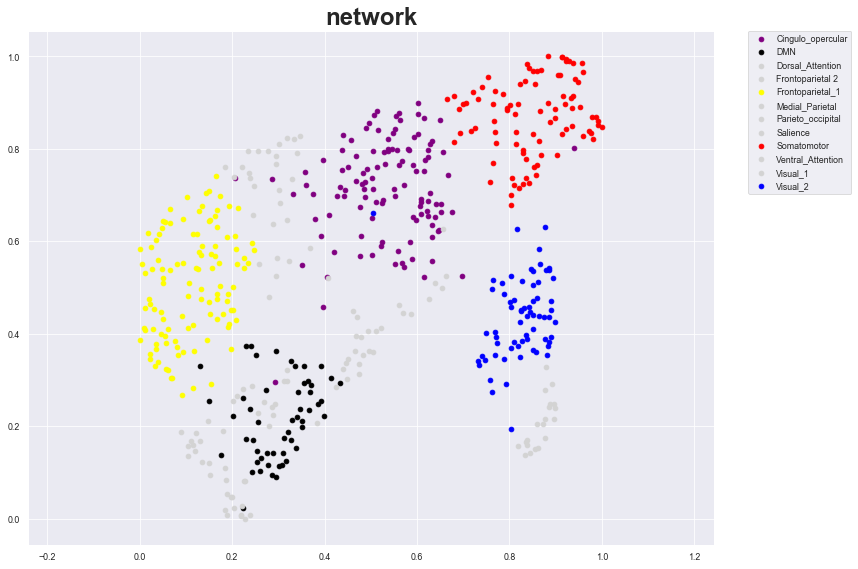

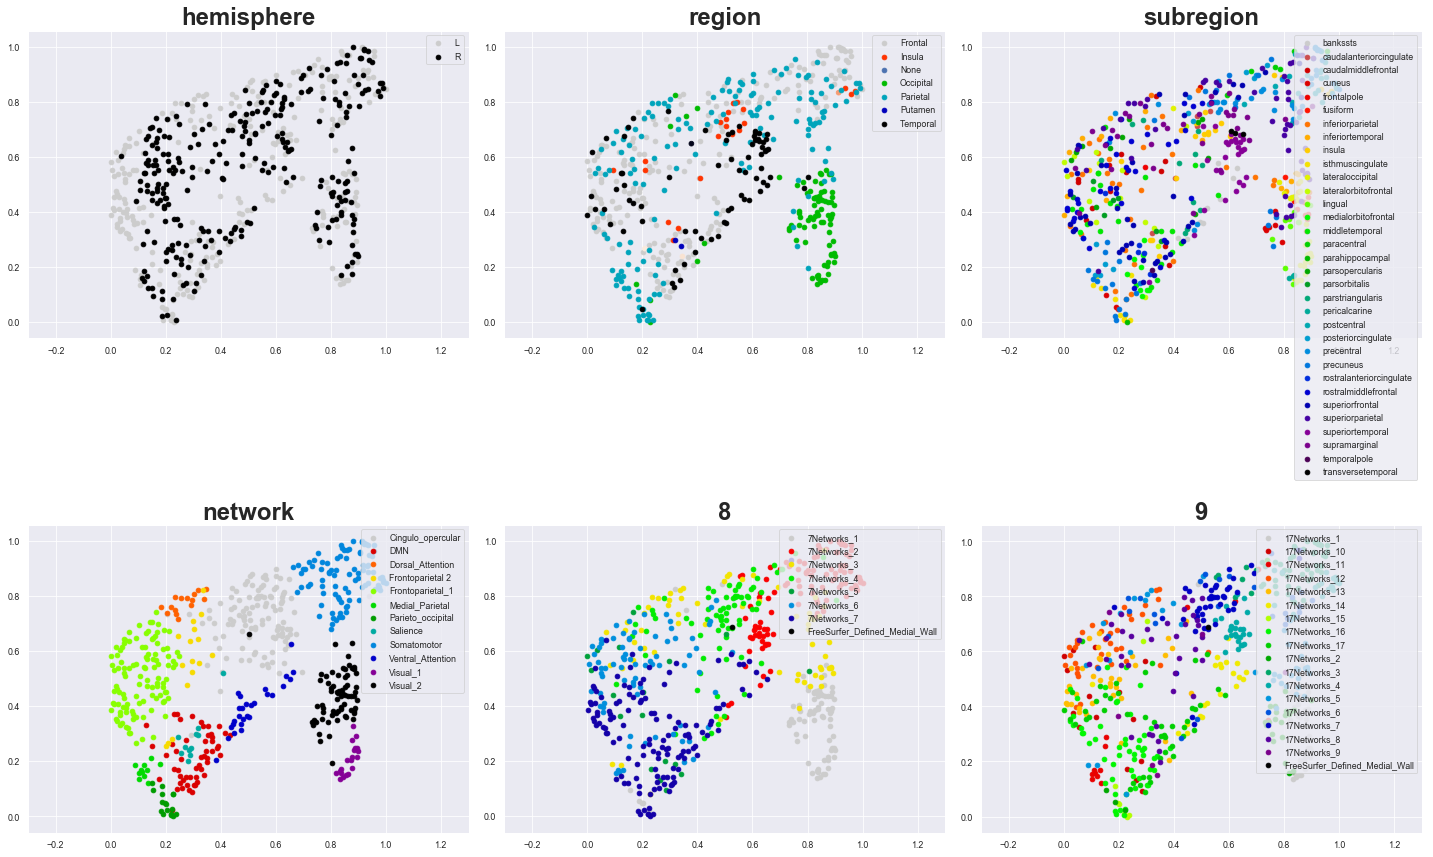

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/fed_spatial_color_RSN_poldrack.html


DyNeuGraph()

<Figure size 432x288 with 0 Axes>

In [288]:
# zscore across TRs
XzT = scipy.stats.zscore(splits.fed.X, axis=0).T

# get optimized clusterer, cluster
from dyneusr.mapper.utils import optimize_dbscan, optimize_cover
config.mapper.clusterer = optimize_dbscan(XzT, min_samples=1)
config.mapper.cover = optimize_cover(XzT, r=40, g=8, limits=True)

# print params
print("projection = {}\n".format(config.mapper.projection))
print("cover = Cover({})\n".format(config.mapper.cover.__dict__))
print("clusterer = {}\n".format(config.mapper.clusterer))

# run
splits.fed.mapped = run_mapper(XzT, **config.mapper)
color_lens_by_atlas(splits.fed, colorby='network', cmap=rsn_colormap)
color_lens_by_atlas(splits.fed)
splits.fed.mapped.dG.visualize('results/fed_spatial_color_RSN_poldrack.html', **config.visualize)

### Network analysis of $fasted$ vs. $fed$ states ###

Compute and visualize network measures on Mapper graphs generated from combined sessions.

i=0  session_id=14  state=fed


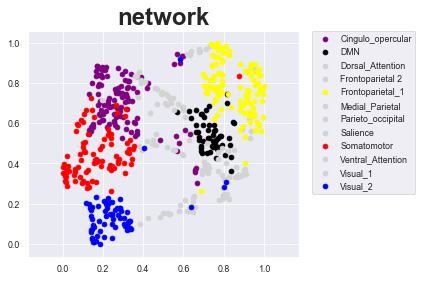

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub14_spatial.html


/Users/calebgeniesse/src/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


                               Q       btw        pc      wmod
state session_id rsn                                          
fed   14         total  0.658596  0.036477  0.294689  0.278833

i=2  session_id=16  state=fast


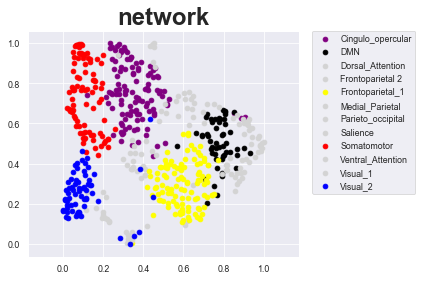

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub16_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fast  16         total  0.673579  0.017969  0.252123  0.256347

i=3  session_id=17  state=fed


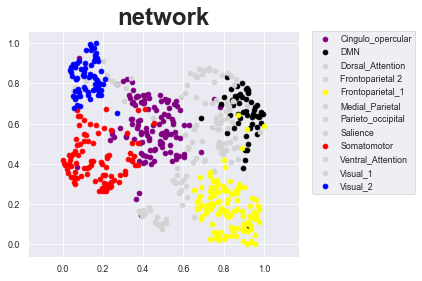

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub17_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fed   17         total  0.693734  0.022639  0.286096  0.254704

i=5  session_id=19  state=fast


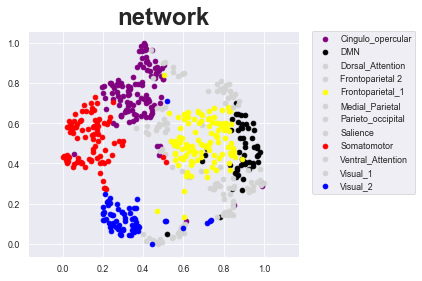

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub19_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fast  19         total  0.684314  0.034084  0.295175  0.278253

i=6  session_id=20  state=fed


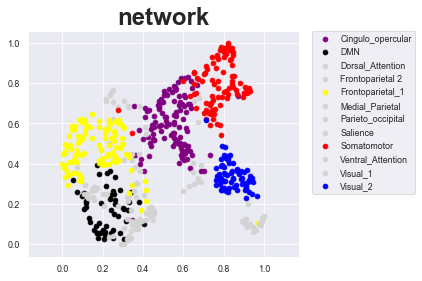

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub20_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fed   20         total  0.678568  0.025105  0.273216  0.295651

i=8  session_id=22  state=fast


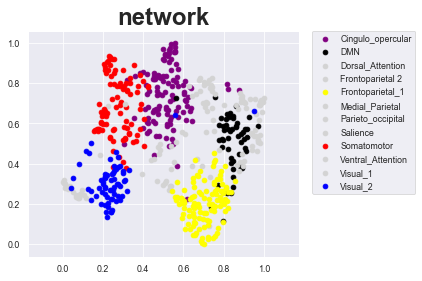

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub22_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fast  22         total  0.684214  0.022616  0.255422  0.277092

i=9  session_id=23  state=fed


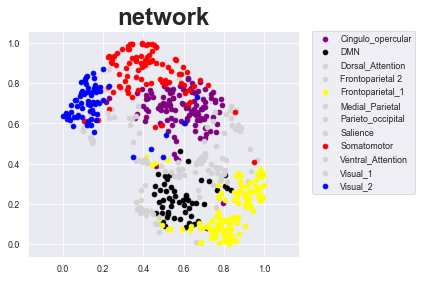

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub23_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fed   23         total  0.630036  0.029243  0.323625  0.218263

i=11  session_id=25  state=fast


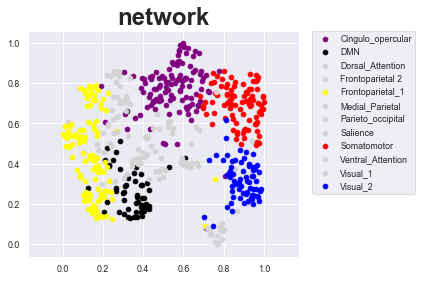

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub25_spatial.html


/Users/calebgeniesse/src/miniconda3/lib/python3.6/site-packages/bct/algorithms/centrality.py:738: RuntimeWarning: invalid value encountered in true_divide
  P = np.ones((n,)) - Kc2 / np.square(Ko)


                               Q       btw        pc      wmod
state session_id rsn                                          
fast  25         total  0.674714  0.022397  0.252062  0.225408

i=12  session_id=26  state=fast


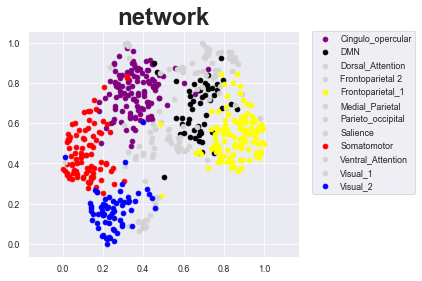

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub26_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fast  26         total  0.676127  0.027017  0.277246  0.229939

i=14  session_id=28  state=fast


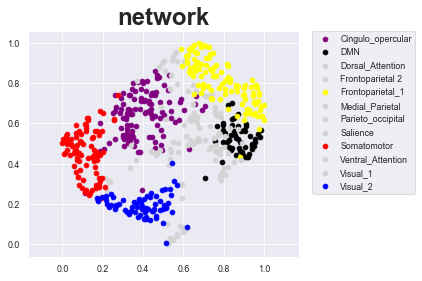

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub28_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fast  28         total  0.670797  0.025251  0.276821  0.238341

i=15  session_id=29  state=fed


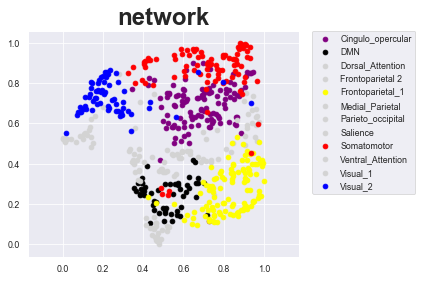

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub29_spatial.html
                               Q       btw        pc     wmod
state session_id rsn                                         
fed   29         total  0.663731  0.025649  0.279078  0.25362

i=17  session_id=32  state=fed


Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub32_spatial.html
                              Q       btw        pc      wmod
state session_id rsn                                         
fed   32         total  0.68558  0.025396  0.250946  0.264058

i=18  session_id=35  state=fed


Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub35_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fed   35         total  0.663072  0.026736  0.252653  0.217752

i=20  session_id=37  state=fast


Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub37_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fast  37         total  0.671394  0.015392  0.265075  0.268729

i=21  session_id=38  state=fed


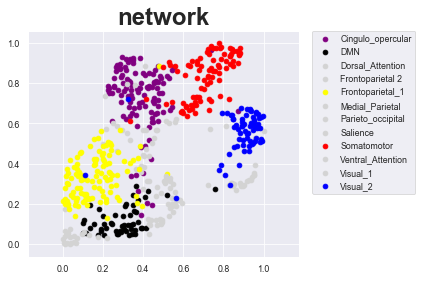

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub38_spatial.html
                               Q      btw       pc      wmod
state session_id rsn                                        
fed   38         total  0.669023  0.02275  0.27835  0.254584

i=22  session_id=39  state=fast


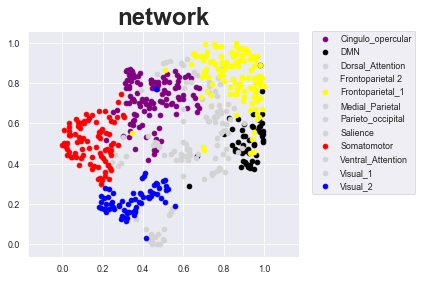

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub39_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fast  39         total  0.678978  0.028209  0.288453  0.253978

i=23  session_id=40  state=fed


Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub40_spatial.html
                               Q       btw       pc      wmod
state session_id rsn                                         
fed   40         total  0.695356  0.027309  0.23019  0.269914

i=25  session_id=42  state=fast


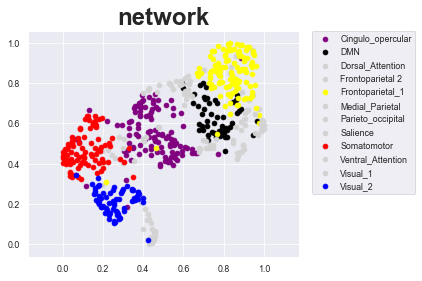

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub42_spatial.html


/Users/calebgeniesse/src/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/calebgeniesse/src/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


                               Q       btw        pc      wmod
state session_id rsn                                          
fast  42         total  0.673828  0.030689  0.265049  0.303938

i=26  session_id=43  state=fed


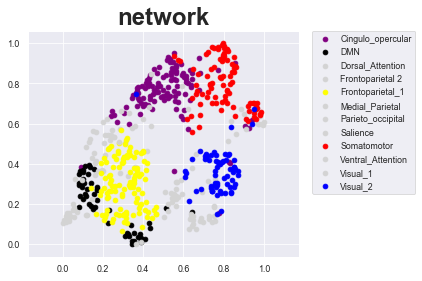

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub43_spatial.html
                               Q       btw        pc     wmod
state session_id rsn                                         
fed   43         total  0.644855  0.029082  0.301938  0.23664

i=28  session_id=45  state=fast


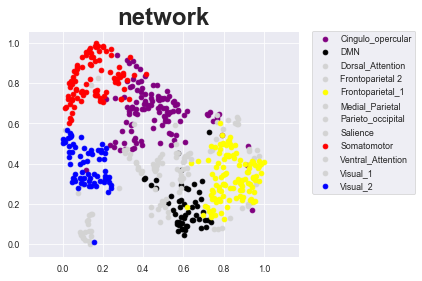

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub45_spatial.html
                               Q      btw        pc      wmod
state session_id rsn                                         
fast  45         total  0.681804  0.02712  0.250436  0.237992

i=30  session_id=47  state=fast


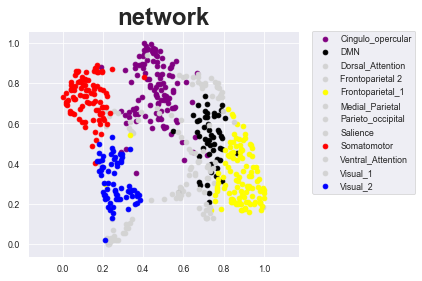

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub47_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fast  47         total  0.678902  0.035502  0.262506  0.238599

i=31  session_id=48  state=fed


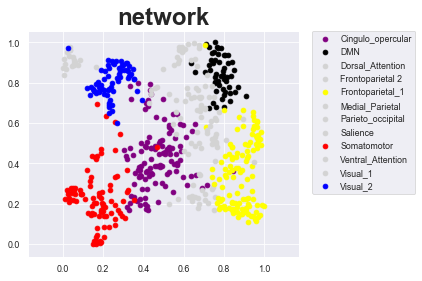

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub48_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fed   48         total  0.678311  0.023613  0.237099  0.233756

i=33  session_id=50  state=fast


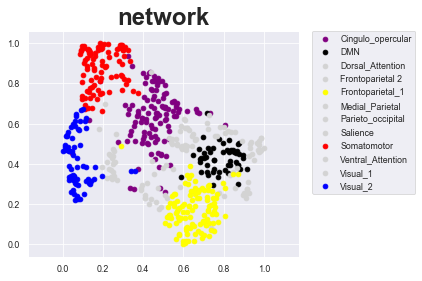

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub50_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fast  50         total  0.697713  0.024282  0.210701  0.227751

i=34  session_id=51  state=fed


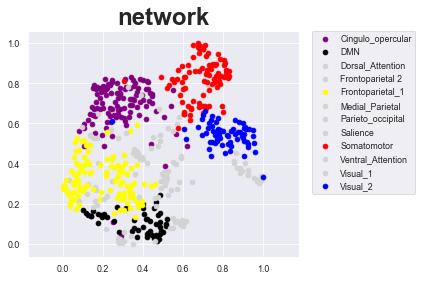

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub51_spatial.html
                               Q       btw       pc      wmod
state session_id rsn                                         
fed   51         total  0.685139  0.022784  0.24208  0.249372

i=36  session_id=54  state=fast


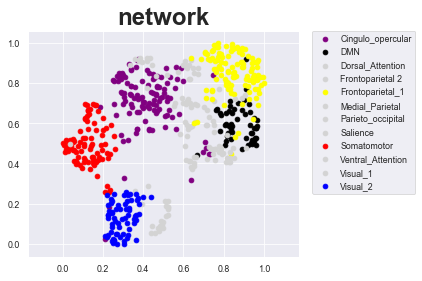

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub54_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fast  54         total  0.677197  0.025379  0.303837  0.277861

i=37  session_id=56  state=fast


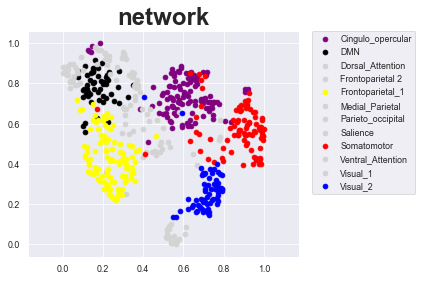

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub56_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fast  56         total  0.679448  0.025388  0.243981  0.279649

i=39  session_id=58  state=fast


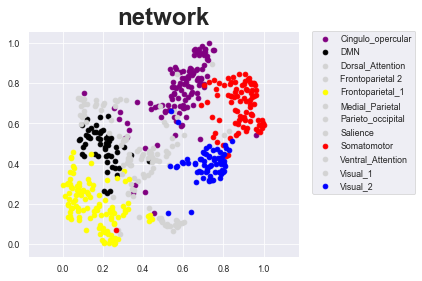

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub58_spatial.html
                               Q       btw       pc      wmod
state session_id rsn                                         
fast  58         total  0.668459  0.037878  0.30801  0.289527

i=40  session_id=59  state=fed


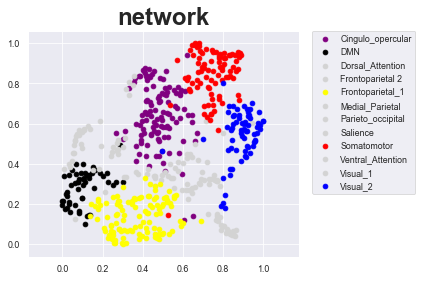

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub59_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fed   59         total  0.683331  0.027359  0.268045  0.211954

i=41  session_id=60  state=fast


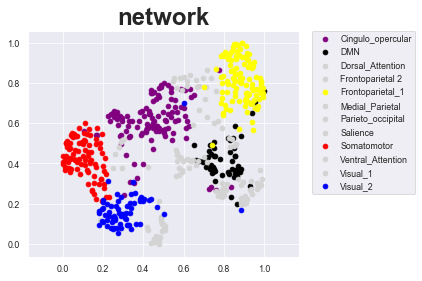

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub60_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fast  60         total  0.689823  0.027284  0.245669  0.212772

i=42  session_id=61  state=fed


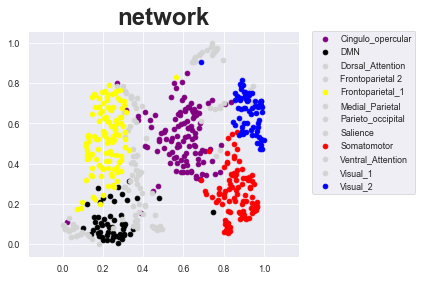

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub61_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fed   61         total  0.683064  0.028312  0.248503  0.286436

i=43  session_id=62  state=fast


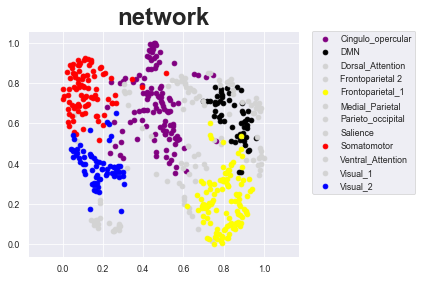

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub62_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fast  62         total  0.670517  0.017258  0.220625  0.202044

i=44  session_id=63  state=fed


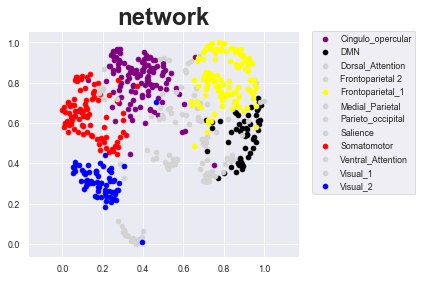

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub63_spatial.html
                              Q       btw        pc      wmod
state session_id rsn                                         
fed   63         total  0.69426  0.024168  0.240248  0.267474

i=45  session_id=64  state=fast


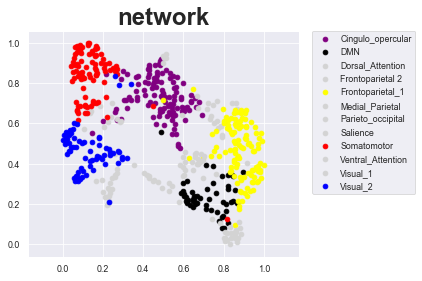

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub64_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fast  64         total  0.700807  0.032972  0.238623  0.245067

i=46  session_id=65  state=fast


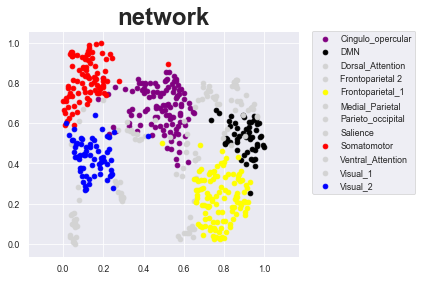

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub65_spatial.html
                              Q       btw        pc      wmod
state session_id rsn                                         
fast  65         total  0.69998  0.021378  0.254645  0.254405

i=47  session_id=66  state=fed


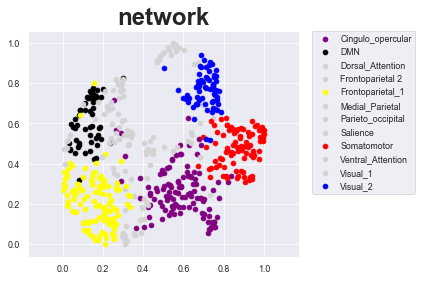

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub66_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fed   66         total  0.670234  0.023485  0.248281  0.224734

i=48  session_id=67  state=fast


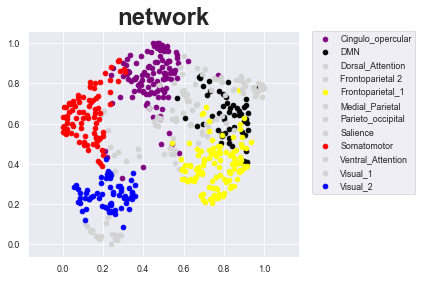

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub67_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fast  67         total  0.655274  0.031428  0.290022  0.215804

i=49  session_id=68  state=fast


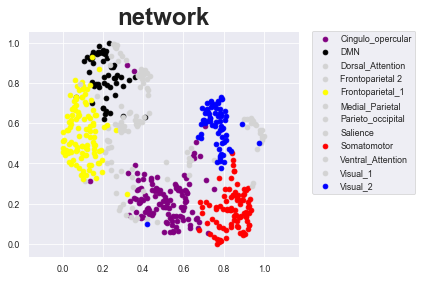

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub68_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fast  68         total  0.678025  0.029299  0.263707  0.250003

i=50  session_id=69  state=fast


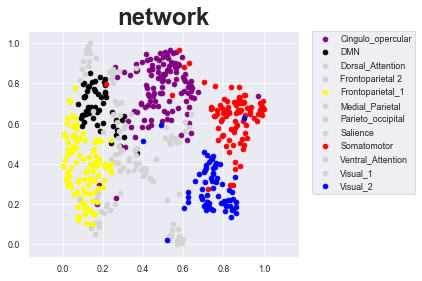

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub69_spatial.html
                               Q       btw       pc      wmod
state session_id rsn                                         
fast  69         total  0.695534  0.018519  0.23977  0.212682

i=51  session_id=70  state=fast


Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub70_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fast  70         total  0.674059  0.028467  0.271439  0.289657

i=52  session_id=71  state=fed


Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub71_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fed   71         total  0.650478  0.025594  0.258036  0.243447

i=53  session_id=72  state=fast


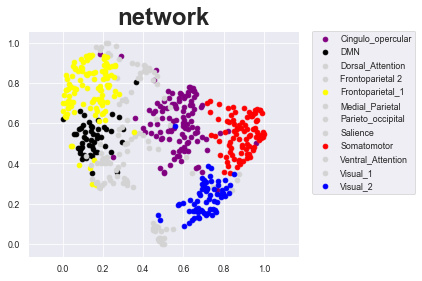

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub72_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fast  72         total  0.676731  0.025489  0.270549  0.281794

i=54  session_id=73  state=fed


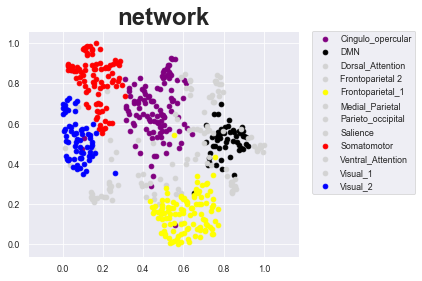

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub73_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fed   73         total  0.705001  0.024171  0.228948  0.256993

i=55  session_id=74  state=fast


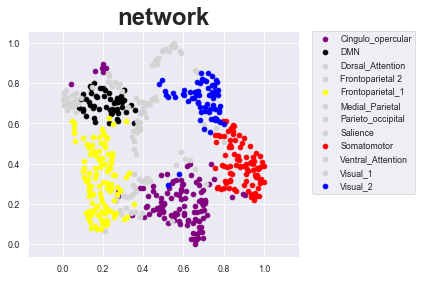

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub74_spatial.html
                               Q      btw        pc      wmod
state session_id rsn                                         
fast  74         total  0.686912  0.02627  0.273072  0.269256

i=56  session_id=75  state=fed


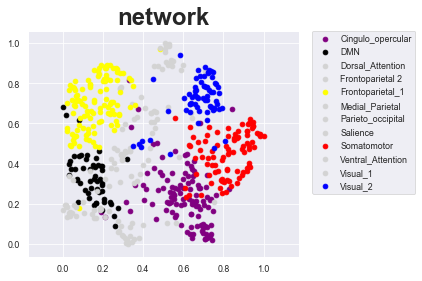

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub75_spatial.html
                               Q       btw       pc      wmod
state session_id rsn                                         
fed   75         total  0.675004  0.023959  0.24554  0.259256

i=57  session_id=76  state=fast


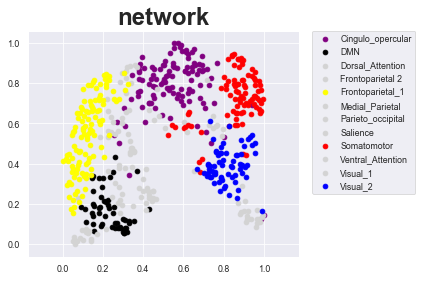

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub76_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fast  76         total  0.659549  0.024356  0.253791  0.218726

i=58  session_id=77  state=fed


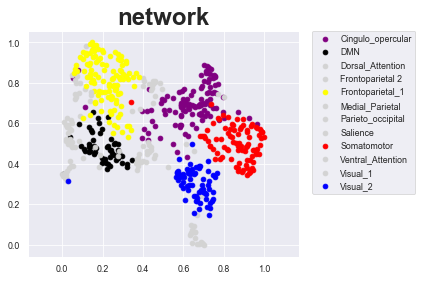

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub77_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fed   77         total  0.671009  0.025187  0.238446  0.280546

i=59  session_id=78  state=fast


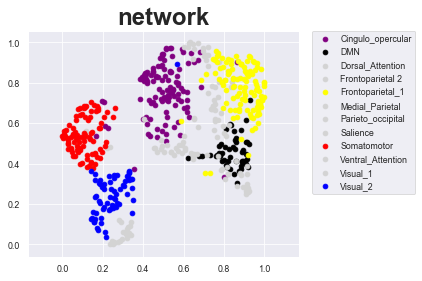

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub78_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fast  78         total  0.659093  0.012502  0.298674  0.272687

i=60  session_id=79  state=fast


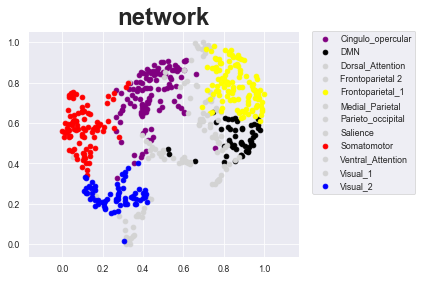

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub79_spatial.html
                              Q       btw        pc      wmod
state session_id rsn                                         
fast  79         total  0.67288  0.030603  0.283435  0.274467

i=61  session_id=80  state=fed


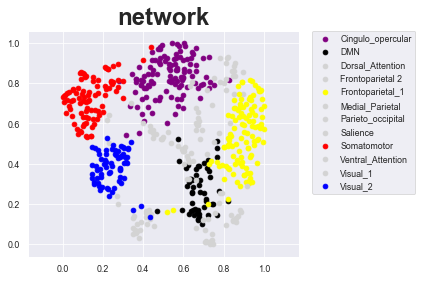

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub80_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fed   80         total  0.708026  0.022157  0.216198  0.222636

i=62  session_id=81  state=fast


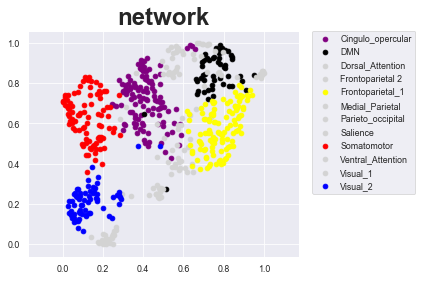

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub81_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fast  81         total  0.684734  0.019266  0.251754  0.263999

i=63  session_id=82  state=fed


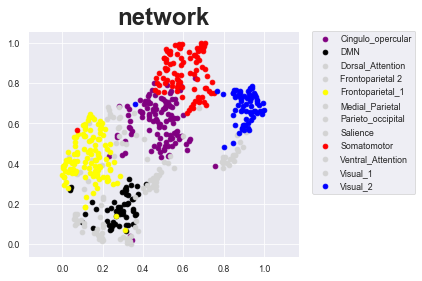

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub82_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fed   82         total  0.678188  0.023499  0.235529  0.275348

i=64  session_id=83  state=fast


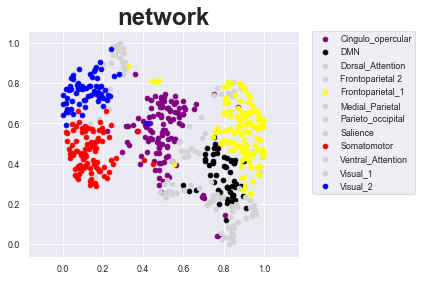

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub83_spatial.html
                               Q       btw        pc     wmod
state session_id rsn                                         
fast  83         total  0.666428  0.025904  0.262778  0.29953

i=65  session_id=84  state=fed


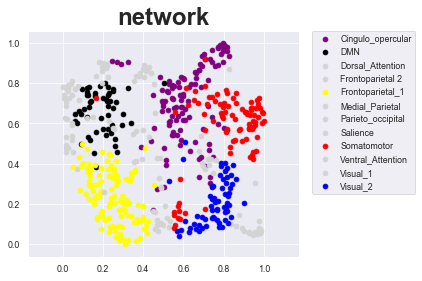

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub84_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fed   84         total  0.680939  0.017756  0.225766  0.243057

i=66  session_id=85  state=fast


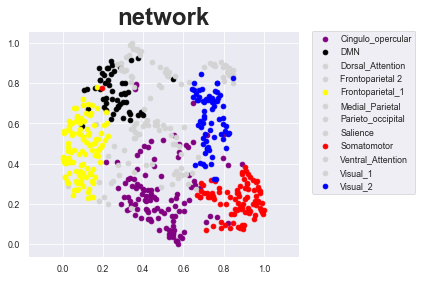

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub85_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fast  85         total  0.645963  0.025735  0.280919  0.235184

i=67  session_id=86  state=fast


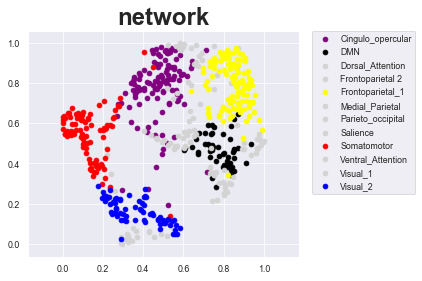

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub86_spatial.html
                             Q       btw        pc      wmod
state session_id rsn                                        
fast  86         total  0.6603  0.027018  0.273593  0.246006

i=68  session_id=87  state=fed


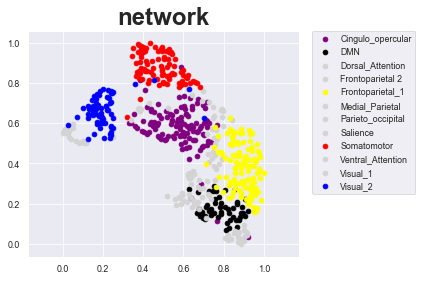

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub87_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fed   87         total  0.661855  0.016668  0.281071  0.301723

i=69  session_id=88  state=fast


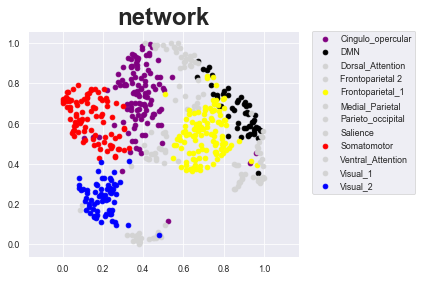

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub88_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fast  88         total  0.692415  0.025923  0.232318  0.242777

i=70  session_id=89  state=fed


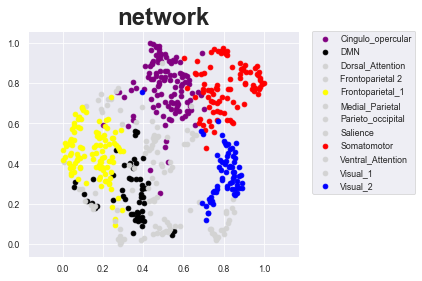

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub89_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fed   89         total  0.661493  0.024878  0.252038  0.195139

i=71  session_id=91  state=fast


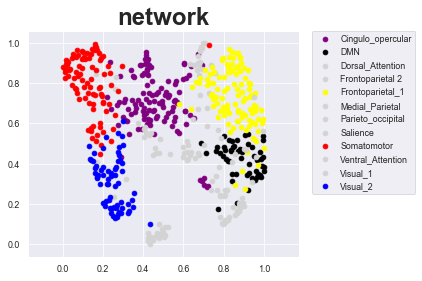

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub91_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fast  91         total  0.661762  0.020429  0.274425  0.232818

i=72  session_id=92  state=fed


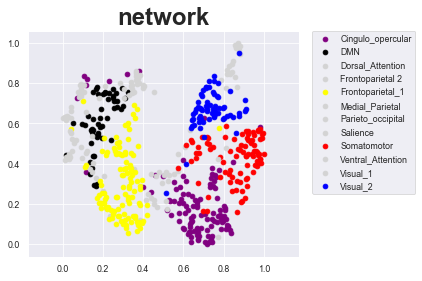

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub92_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fed   92         total  0.667514  0.025186  0.256701  0.249738

i=73  session_id=94  state=fast


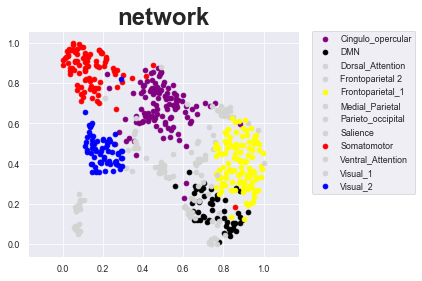

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub94_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fast  94         total  0.675956  0.023059  0.219864  0.265993

i=74  session_id=95  state=fast


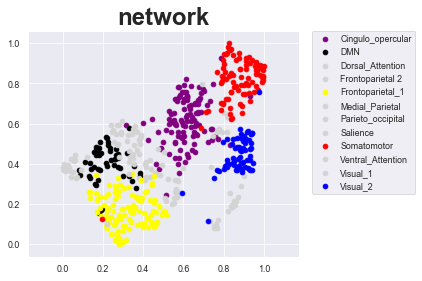

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub95_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fast  95         total  0.681934  0.025638  0.226027  0.241915

i=75  session_id=96  state=fed


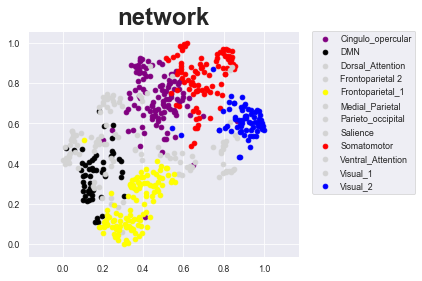

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub96_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fed   96         total  0.677564  0.022998  0.257747  0.245788

i=76  session_id=97  state=fast


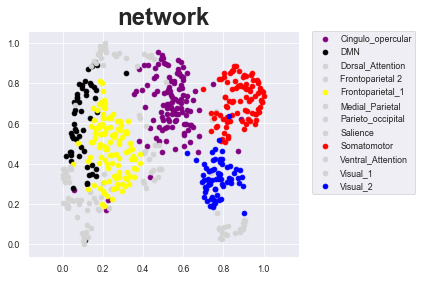

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub97_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fast  97         total  0.693541  0.018709  0.241939  0.268641

i=77  session_id=98  state=fed


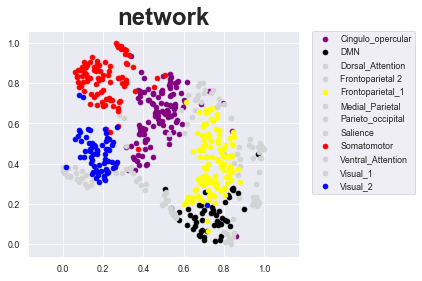

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub98_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fed   98         total  0.675888  0.022054  0.245689  0.228312

i=78  session_id=99  state=fast


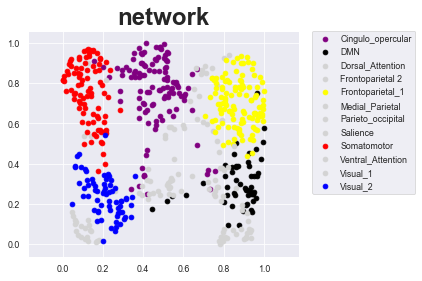

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub99_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fast  99         total  0.701274  0.011815  0.235959  0.214637

i=79  session_id=100  state=fed


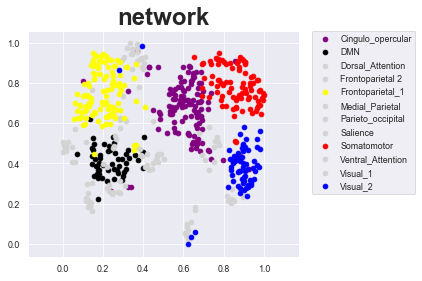

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub100_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fed   100        total  0.675674  0.018913  0.266396  0.231064

i=80  session_id=101  state=fast


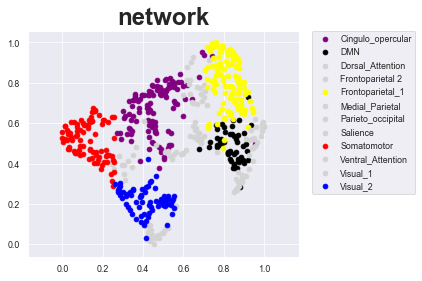

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub101_spatial.html
                               Q       btw        pc      wmod
state session_id rsn                                          
fast  101        total  0.681062  0.027356  0.270984  0.305737

i=81  session_id=102  state=fed


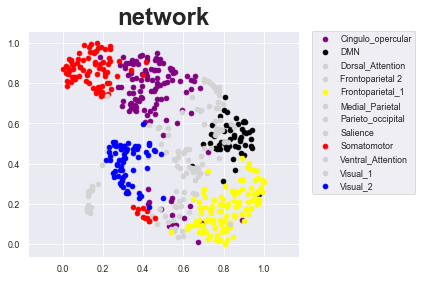

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub102_spatial.html
                               Q       btw       pc      wmod
state session_id rsn                                         
fed   102        total  0.691551  0.024961  0.24071  0.233064

i=82  session_id=103  state=fed


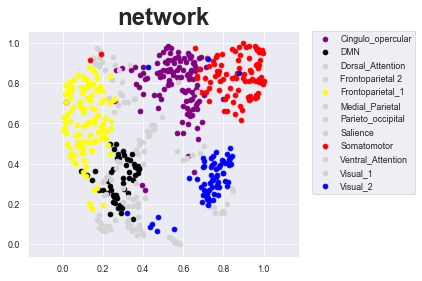

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fed_sub103_spatial.html
                               Q       btw        pc     wmod
state session_id rsn                                         
fed   103        total  0.696163  0.028552  0.237967  0.21754

i=83  session_id=104  state=fast


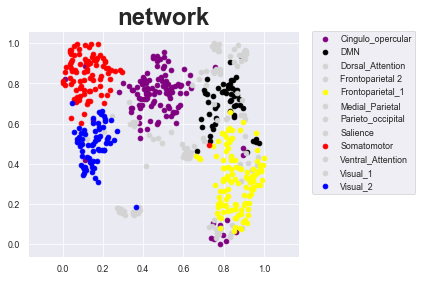

Already serving localhost:8000 
[Force Graph] http://localhost:8000/results/session_fast_sub104_spatial.html
                              Q       btw        pc      wmod
state session_id rsn                                         
fast  104        total  0.69642  0.023101  0.218812  0.257063



In [292]:
# group meta by session (i.e. 1 row per session)
df_state = combined.meta.groupby('session_id').first()
df_state = df_state.reset_index(drop=False)

# limit to panas, session, day of week
panas_cols = [_ for _ in df_state.columns if 'panas:' in _]
state_cols = ['session_id', 'day_of_week'] + panas_cols
df_state = df_state[state_cols]


# save scores here
df_scores = pd.DataFrame()


# get scores for each session
for session_ind, session in enumerate(sessions):
    
    # dat
    meta_ = session.meta.reset_index(drop=False)
    day, session_id = meta_.loc[0, ['day_of_week', 'session_id']]
    try:
        day = int(day)
    except:
        day = {'tue':2, 'thu':4}.get(str(day).lower()) or 0
    # map day to state
    state = {2:'fast', 4:'fed'}.get(day)
    if state is None:
        continue
        
    print("i={}  session_id={}  state={}"
          .format(session_ind, session_id, state))
    
    # Run Mapper/DyNeuSR
    if session.get('mapped') is None:
        # zscore across TRs
        XzT = scipy.stats.zscore(session.X, axis=0).T

        # get optimized clusterer, cluster
        from dyneusr.mapper.utils import optimize_dbscan, optimize_cover
        config.mapper.zscore = False
        config.mapper.clusterer = optimize_dbscan(XzT, min_samples=1)
        config.mapper.cover = optimize_cover(XzT, r=40, g=8, limits=True)
        
        # print params
        print("projection = {}\n".format(config.mapper.projection))
        print("cover = Cover({})\n".format(config.mapper.cover.__dict__))
        print("clusterer = {}\n".format(config.mapper.clusterer))
       
        # run mapper
        session.mapped = run_mapper(XzT, **config.mapper)
    
    # visualize
    config.visualize.show = False
    config.visualize.path_html = 'results/session_{}_sub{}_spatial.html'.format(state, session_id)
    color_lens_by_atlas(session, colorby='network', cmap=rsn_colormap, figsize=(6, 4), layout=(1, 1))
    session.mapped.dG.visualize(**config.visualize)
        
    
    # get result from session
    mapped = session.mapped
    G = mapped.dG.G.copy()
    TCM = mapped.dG.TCM.copy()
    A = mapped.dG.A.copy()
    
    # Network analysis
    Q, part = get_mod(G, return_partition=True)
    C = [np.where(RSN_LABELS == part[node]) for node in G.nodes()] 
    
    # PE
    pc = calc_particip(G, part, A, C)    
    btw = betweenness(G, part)
    wmod = within_module_degree(G, part, normalize=True)
  
    # save
    df_ = pd.DataFrame().assign(
        rsn=RSN_LABELS, Q=Q,
        wmod=[np.mean(wmod[_]) for _ in RSN_LABELS],
        pc=[np.mean(pc[_]) for _ in RSN_LABELS],
        btw=[np.mean(btw[_]) for _ in RSN_LABELS],
      )
    
    # append mean row
    df_ = df_.append(
        df_.mean().to_frame().T.assign(rsn='total')
        , ignore_index=True
      )
    
    # assign state things
    df_ = df_.assign(state=state, session_id=session_id)
       
    # print this
    print(df_.set_index(['state', 'session_id', 'rsn']).tail(1))
    print()
    
    # append to scores
    df_scores = df_scores.append(df_)
    
    
# join scores with state
df_state = df_state.join(df_scores.set_index('session_id'), on='session_id')
df_state.to_csv('session_state_and_metrics.csv')

In [243]:
df_state.loc[:1, ['session_id', 'day_of_week', 'panas:fatigue', 'rsn', 'pc']]

session_id day_of_week  panas:fatigue                rsn        pc
0          14           4      -0.979336  Cingulo_opercular  0.247162
0          14           4      -0.979336   Frontoparietal_1  0.148069
0          14           4      -0.979336        Somatomotor  0.171423
0          14           4      -0.979336           Visual_2  0.085305
0          14           4      -0.979336                DMN  0.293766
0          14           4      -0.979336   Dorsal_Attention  0.510924
0          14           4      -0.979336  Ventral_Attention  0.274608
0          14           4      -0.979336           Salience  0.571703
0          14           4      -0.979336           Visual_1  0.093529
0          14           4      -0.979336    Medial_Parietal  0.347704
0          14           4      -0.979336  Parieto_occipital  0.266671
0          14           4      -0.979336   Frontoparietal 2  0.525403
0          14           4      -0.979336              total  0.294689
1          15           1      -0.979336                NaN       NaN

In [244]:
df_state.set_index('rsn').loc['Somatomotor', ['session_id', 'day_of_week', 'panas:fatigue', 'pc']].head(20)

session_id day_of_week  panas:fatigue        pc
rsn                                                         
Somatomotor          14           4      -0.979336  0.171423
Somatomotor          16           2       0.191604  0.109487
Somatomotor          17           4      -0.979336  0.097855
Somatomotor          19           2       0.191604  0.089949
Somatomotor          20           4      -0.979336  0.128459
Somatomotor          22           2      -0.393866  0.137726
Somatomotor          23           4      -0.979336  0.139893
Somatomotor          25           2       0.191604  0.102751
Somatomotor          26           2       2.240749  0.088641
Somatomotor          28           2       0.191604  0.098587
Somatomotor          29           4       0.191604  0.174221
Somatomotor          32           4      -0.979336  0.089512
Somatomotor          35           4      -0.979336  0.074611
Somatomotor          37           2       0.191604  0.139252
Somatomotor          38           4       0.191604  0.100889
Somatomotor          39           2       0.191604  0.115559
Somatomotor          40           4      -0.979336  0.102089
Somatomotor          42           2       1.655279  0.145997
Somatomotor          43           4       0.191604  0.134365
Somatomotor          45           2       0.191604  0.102742

panas:fatigue
0 total
0 pc
1 btw
2 wmod


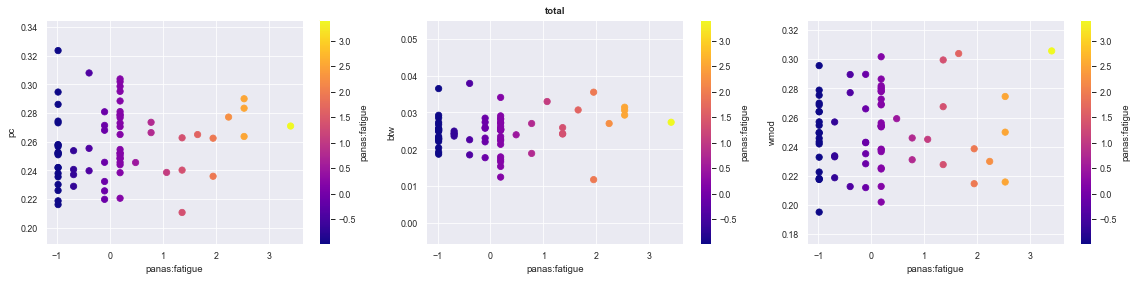

1 Cingulo_opercular
0 pc
1 btw
2 wmod


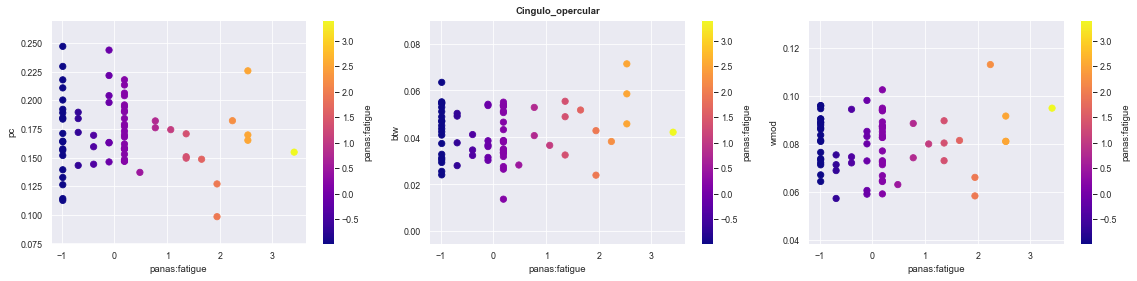

2 Frontoparietal_1
0 pc
1 btw
2 wmod


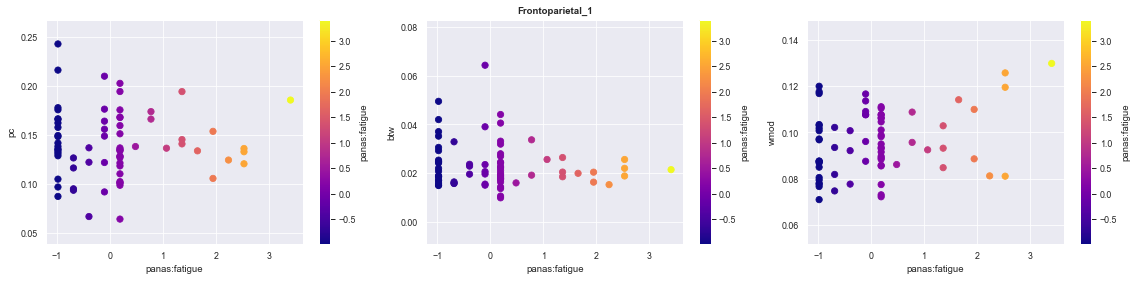

3 Somatomotor
0 pc
1 btw
2 wmod


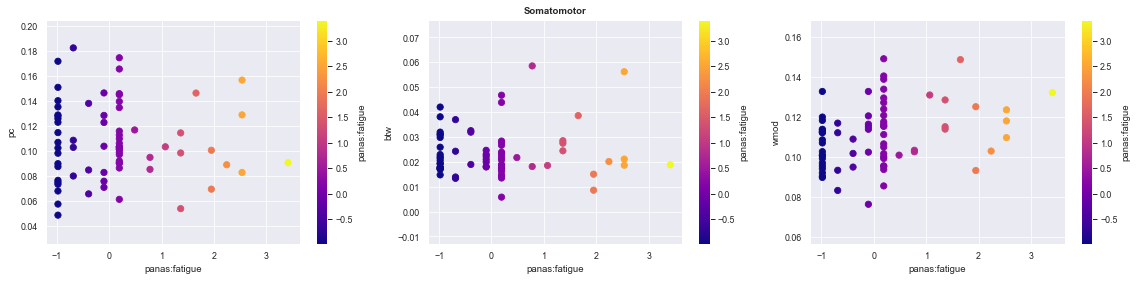

4 Visual_2
0 pc
1 btw
2 wmod


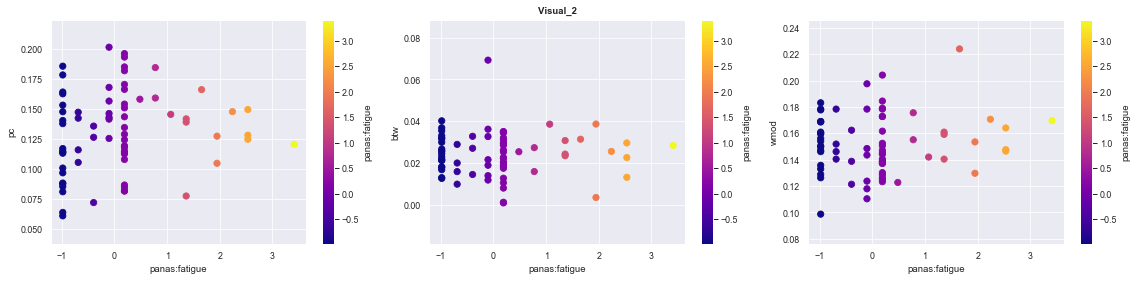

5 DMN
0 pc
1 btw
2 wmod


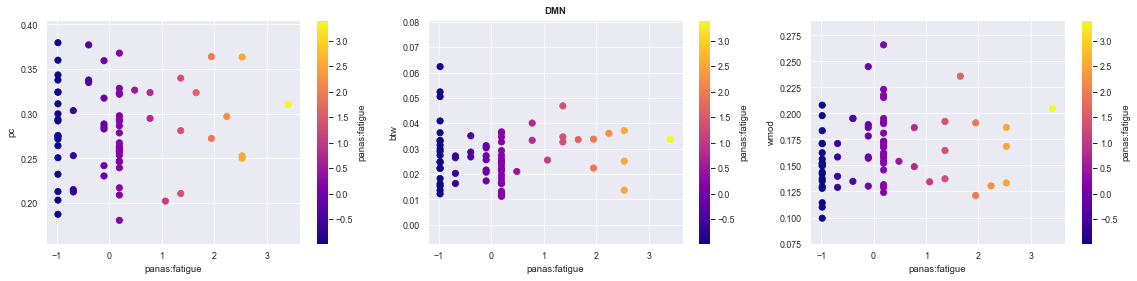

6 Dorsal_Attention
0 pc
1 btw
2 wmod


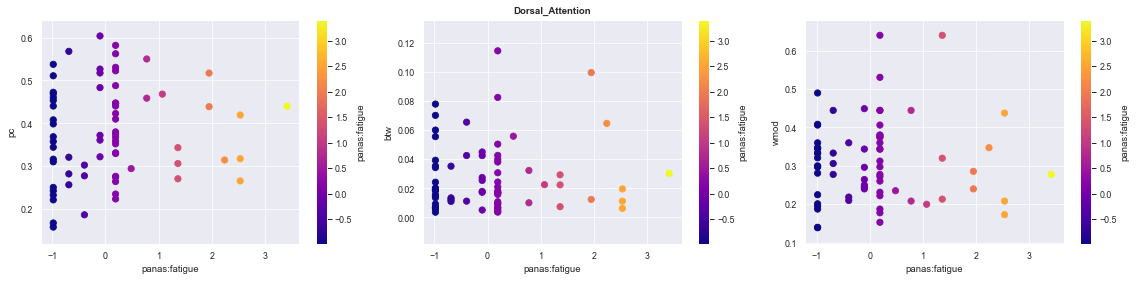

7 Ventral_Attention
0 pc
1 btw
2 wmod


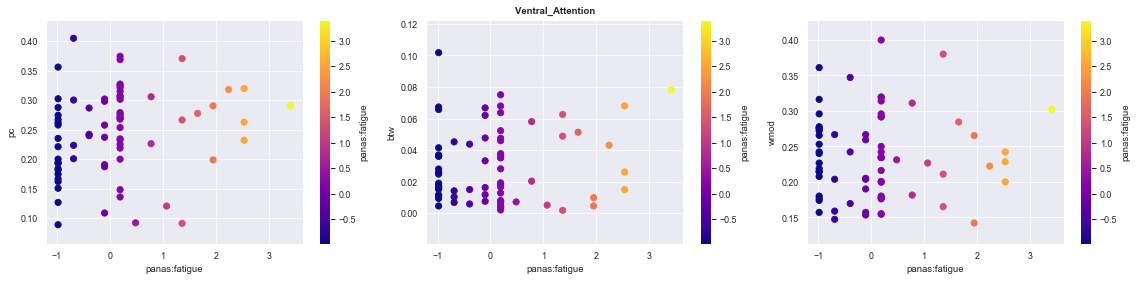

8 Salience
0 pc
1 btw
2 wmod


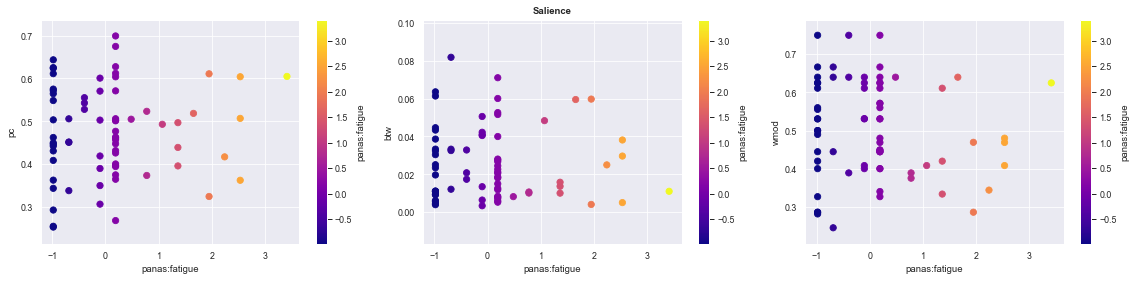

9 Visual_1
0 pc
1 btw
2 wmod


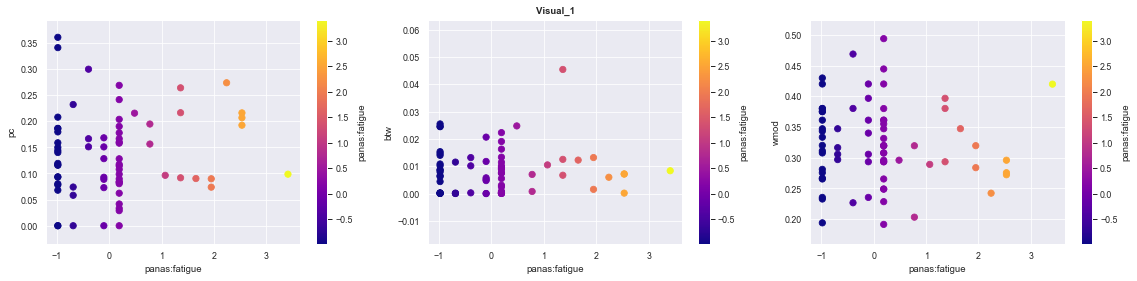

10 Medial_Parietal
0 pc
1 btw
2 wmod


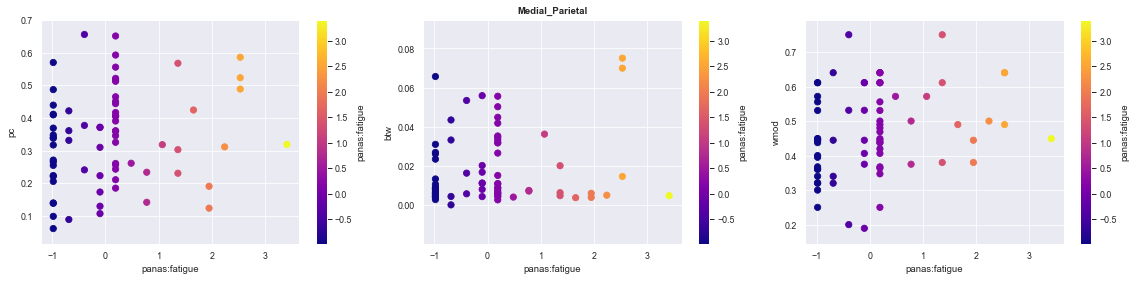

11 Parieto_occipital
0 pc
1 btw
2 wmod


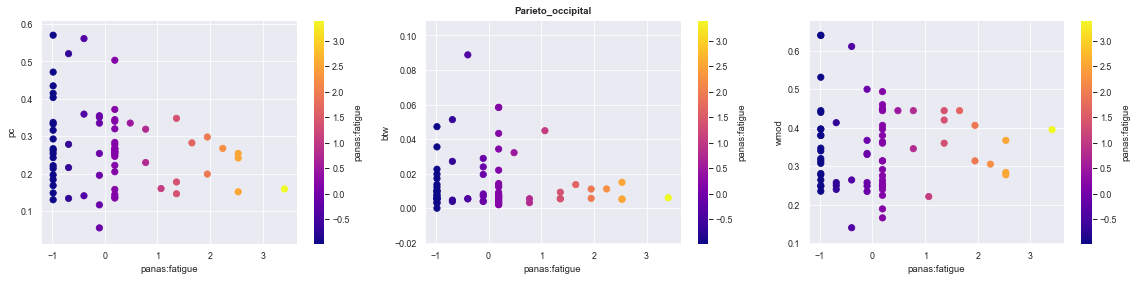

12 Frontoparietal 2
0 pc
1 btw
2 wmod


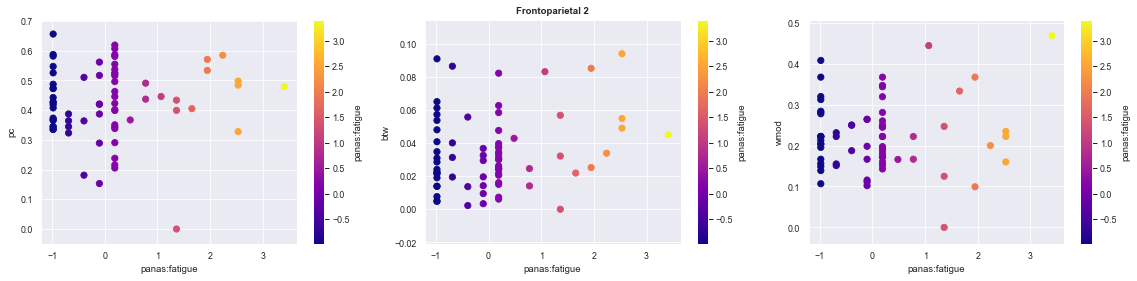

In [304]:
import seaborn as sns
sns.set_style('darkgrid')

# columns to plot
xcols = ['panas:fatigue']
ycols = ['pc', 'btw', 'wmod']
    
for xcol in xcols:
    print(xcol)
    
    for i, rsn in enumerate(['total']+list(RSN_LABELS)):
        print(i, rsn)

        # plot ycols, xcol for each rsn
        fig, axes = plt.subplots(1, len(ycols), figsize=(16, 4))
        for j,ycol in enumerate(ycols):    
            print(j, ycol)
            df_ = df_state.loc[df_state.rsn == rsn, :].copy()
            df_['day_of_week'] = df_['day_of_week'].astype(int)
            df_ = df_.loc[df_.day_of_week.isin([2, 4]), :]
            df_.plot(
                kind='scatter', x=xcol, y=ycol, 
                marker='o', s=40, c='panas:fatigue', 
                cmap='plasma', ax=axes[j],
                )
            
        # set title on middle 
        axes[1].set_title(rsn, fontweight='bold')

        # show
        plt.tight_layout()
        plt.show()

### Compare ROI x ROI Adjacency of $fasted$ vs. $fed$ states ###


494    Cingulo_opercular
111    Cingulo_opercular
112    Cingulo_opercular
114    Cingulo_opercular
115    Cingulo_opercular
364    Cingulo_opercular
363    Cingulo_opercular
121    Cingulo_opercular
524    Cingulo_opercular
127    Cingulo_opercular
128    Cingulo_opercular
361    Cingulo_opercular
360    Cingulo_opercular
359    Cingulo_opercular
357    Cingulo_opercular
356    Cingulo_opercular
110    Cingulo_opercular
109    Cingulo_opercular
108    Cingulo_opercular
107    Cingulo_opercular
368    Cingulo_opercular
367    Cingulo_opercular
89     Cingulo_opercular
90     Cingulo_opercular
91     Cingulo_opercular
92     Cingulo_opercular
93     Cingulo_opercular
143    Cingulo_opercular
95     Cingulo_opercular
97     Cingulo_opercular
             ...        
560                 zero
559                 zero
558                 zero
557                 zero
556                 zero
555                 zero
554                 zero
628                 zero
568                 zero


IndexError: index 13 is out of bounds for axis 0 with size 13

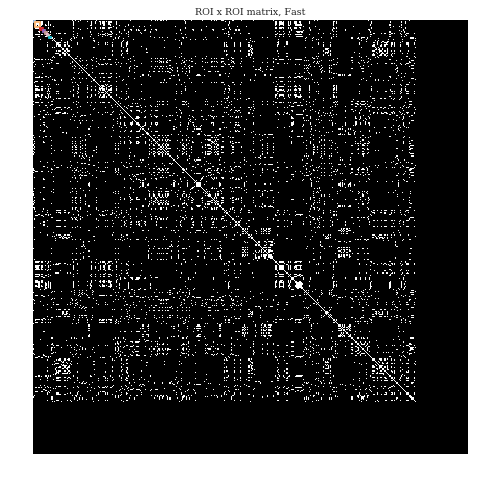

In [309]:
config.figsize = (8, 8)
print(RSNs)

# plot ROI x ROI adj
plot_network_adj(
    splits.fast.mapped.dG.TCM,'ROI x ROI matrix, Fast',add_cbar=True,
    figure=plt.figure(figsize=config.figsize), labels=RSNs,
    )
plot_network_adj(
    splits.fed.mapped.dG.TCM,'ROI x ROI matrix, Fed', add_cbar=True,  
    figure=plt.figure(figsize=config.figsize), labels=RSNs,
    )
plot_network_adj(
    splits.fed.mapped.dG.TCM - splits.fast.mapped.dG.TCM,
    'ROI x ROI matrix, Fed - Fasted', add_cbar=True, 
    figure=plt.figure(figsize=config.figsize), labels=RSNs,
    )
plot_network_adj(
    splits.fed.mapped.dG.TCM + splits.fast.mapped.dG.TCM,
    'ROI x ROI matrix, Fasted + Fed', add_cbar=True, 
    figure=plt.figure(figsize=config.figsize), labels=RSNs,
    )

In [ ]:
config.figsize = (8, 8)

# Average FC (fast)
fc = [np.corrcoef(s.X.T) for s in sample_sessions]
fc_fast = [np.corrcoef(s.X.T) for s,_ in zip(sample_sessions, fc) if s.meta.day_of_week[0]==2]
fc_fed = [np.corrcoef(s.X.T) for s,_ in zip(sample_sessions, fc) if s.meta.day_of_week[0]==4]

# get mean of each
fcmean = np.mean(fc, axis=0)
fcmean_fast = np.mean(fc_fast, axis=0)
fcmean_fed = np.mean(fc_fed, axis=0)

# Average FC 
plot_network_adj(
    fcmean,'Average FC across sessions', 
    figure=plt.figure(figsize=config.figsize))


# Average FC (FAST)
plot_network_adj(
    fcmean_fast,'Average FC across sessions (FAST)', 
    figure=plt.figure(figsize=config.figsize))

# Average FC (FAST)
plot_network_adj(
    fcmean_fed,'Average FC across sessions (FED)', 
    figure=plt.figure(figsize=config.figsize))


# Average FC (FED - FAST)
plot_network_adj(
    (fcmean_fast - fcmean), 'Average FC across sessions (FAST - All)', 
    figure=plt.figure(figsize=config.figsize))


# Average FC (FED - FAST)
plot_network_adj(
    (fcmean_fed - fcmean), 'Average FC across sessions (FED - ALL)', 
    figure=plt.figure(figsize=config.figsize))


## $MAPPER$ analysis of $fasted$ vs. $fed$ state across individual sessions ##


### Comparing ROI x ROI Adjacency to average Functional Connectivity ###

Here, we visualize the __ROI x ROI adjacency matrix (RAM)__, where each row or column is a subject-specific parcellated brain region. The matrix was averaged across scans: 40 for fasted, 40 for fed, and all 84 for SBM. Comparing these to the average correlation matrix of the ROI timeseries across all scans shows that Mapper captures these relationships.

In [ ]:
# Fast
Afast_mean = np.mean(Afast,axis=0)
plot_network_adj(Afast_mean, 'ROI x ROI matrix, Fast')
plt.savefig('figures/fast_ram.jpg',dpi=300)

# Fed
Afed_mean = np.mean(Afed,axis=0)
plot_network_adj(Afed_mean,'ROI x ROI matrix, Fed')
plt.savefig('figures/fed_ram.jpg',dpi=300)

# SBM
#SBM.plot()
#plt.savefig('figures/fast_sbm.jpg',dpi=300)

# Average FC
fc = [np.corrcoef(session.X.T) for session in sample_sessions]
fcmean = np.mean(fc,axis=0)
plot_network_adj(fcmean,'Average functional connectivity across sessions')
plt.savefig('figures/fc_ram.jpg',dpi=300)

### Modularity of resting state networks across sessions ###

Comparison of __graph modularity__ by using RSN labels as community assignments. __Real brain graphs exhibit a higher modularity than the random graph model__, but the fed and fasted states show similar modularity.

In [ ]:
Qfed_mean = np.mean(Qfed)
Qfed_std = np.std(Qfed)
Qfast_mean = np.mean(Qfast)
Qfast_std = np.std(Qfast)
Qnull_mean = np.mean(Qnull)
Qnull_std = np.std(Qnull)

barlabels = ['Fed','Fasted','SBM']
barh = [Qfed_mean,Qfast_mean,Qnull_mean]
barerr = [Qfed_std,Qfast_std,Qnull_std]
bar_width = 0.15
cmap = plt.cm.get_cmap('viridis', 20)
colors = cmap(np.linspace(0,1,10))

plt.close('all')
plt.figure(figsize=(4.5,4))
plt.bar([0.25,0.50,0.75],barh,bar_width,yerr=barerr,color=[colors[2],colors[7],'gray'])
plt.xticks([0.25,0.50,0.75], barlabels, fontsize=10)
plt.ylabel('Modularity')
plt.title('Modularity of resting state networks across sessions', fontsize=11)
fig = plt.gcf()
fig.tight_layout()
plt.savefig('figures/mod.jpg',dpi=300)
plt.show()

### Participation coefficient of resting state networks across sessions ###

Comparison of __participation coefficient__ among the three types of graphs. Values were averaged across all nodes within an RSN within a scan, and then averaged across all scans.

In [ ]:
rsnstats_fed = collections.defaultdict(list)
for session in p_fed:
    for rsn in session:
        rsnstats_fed[rsn].append(np.mean(session[rsn]))
        
rsnstats_fast = collections.defaultdict(list)
for session in p_fast:
    for rsn in session:
        rsnstats_fast[rsn].append(np.mean(session[rsn]))
        
rsnstats_null = collections.defaultdict(list)
for session in p_null:
    for rsn in session:
        rsnstats_null[rsn].append(np.mean(session[rsn]))
        
plot_network_measure(rsnstats_fed,rsnstats_fast,
                     'Average participation coefficient',
                     'Participation coefficient of resting-state networks in fed vs fasted states',
                     0.8,
                     null_measure=rsnstats_null
                    )
plt.savefig('figures/particip.jpg',dpi=300)

### Within-module connectivity of resting state networks across sessions ###

Comparison of __within-module connectivity__ among the three types of graphs. Values were averaged across all nodes within an RSN within a scan, and then averaged across all scans. Within module degree was normalized by community size to remove the possibility that larger communities had a higher chance of created edges within itself.

In [ ]:
rsnstats_fed = collections.defaultdict(list)
for session in wmod_fed:
    for rsn in session:
        rsnstats_fed[rsn].append(np.mean(session[rsn]))

rsnstats_fast = collections.defaultdict(list)
for session in wmod_fast:
    for rsn in session:
        rsnstats_fast[rsn].append(np.mean(session[rsn]))
        
rsnstats_null = collections.defaultdict(list)
for session in wmod_null:
    for rsn in session:
        rsnstats_null[rsn].append(np.mean(session[rsn]))
        
plot_network_measure(rsnstats_fed,rsnstats_fast,
                     'Average within-module degree, normalized',
                     'Within-module connectivity of resting-state networks in fed vs fasted states',
                     0.8,
                     null_measure=rsnstats_null
                    )
plt.savefig('figures/wmod.jpg',dpi=300)

### Betweenness centrality of resting state networks across sessions ###

Comparison of __betweenness centrality__ among the three types of graphs. Values were averaged across all nodes within an RSN within a scan, and then averaged across all scans. 

In [ ]:
rsnstats_fed = collections.defaultdict(list)
for session in btw_fed:
    for rsn in session:
        rsnstats_fed[rsn].append(np.mean(session[rsn]))
        
rsnstats_fast = collections.defaultdict(list)
for session in btw_fast:
    for rsn in session:
        rsnstats_fast[rsn].append(np.mean(session[rsn]))
        
rsnstats_null = collections.defaultdict(list)
for session in btw_null:
    for rsn in session:
        rsnstats_null[rsn].append(np.mean(session[rsn]))
        
plot_network_measure(rsnstats_fed,rsnstats_fast,
                     'Average betweenness centrality',
                     'Betweenness of resting-state networks in fed vs. fasted states',
                     0.1,
                     null_measure=rsnstats_null
                    )
plt.savefig('figures/btw.jpg',dpi=300)

# Discussion #

 - Fasted state exhibits __increased participation coefficient__ across almost all resting state networks compared to fed state


 - Both real brain graphs showed __higher participation, within-module connectivity,__ and __modularity__ across all resting state networks compared to the null model


 - Greater structure within a network vs. null model



## Conclusions ##

 - Mapper graphs capture brain’s ability to optimize the balance between integration and segregation of function


 - The results from this study show that Mapper  can  reveal  important  anatomical  and  functional  architecture  of  the human brain


 - Running Mapper in anatomical space can be used to highlight physiologically relevant anatomical regions of interest to guide further analysis


# Contributions #

R.A. and C.G. designed the experiments. C.G. collected and cleaned the data. R.A. and C.G. developed and implemented preprocessing and analysis methods. R.A. and C.G. performed and interpreted analyses. R.A. drafted a manuscript (for CS 224W) and C.G. combined relevent parts of this writeup with analysis code and results into a final computational notebook. 

# Acknowledgments #

Funding was provided by a Graduate Research Fellowship (NIH-GRF) from the National Science Foundation (NSF) to R.A., and a Biophysics Training Grant (GM008294) from the National Institute of Health (NIH) to C.G.

# References #

**1** Glomb, 2017 <br>
**2** Hansen, 2015 <br>
**3** Deco, 2013 <br>
**4** Greicius, 2008<br>
**5** Poldrack, 2015<br>
**6** Saggar, 2018<br>
**7** Esteban, 2018<br>
**8** Singh, 2007<br>
**9** VanderMaaten, 2008<br>
**10** McInnes, 2017<br>
**11** Abbe, 2017<br>
